## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] =14
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
plt.style.use('grayscale')

df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

/usr/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [2]:
dfs[0].head()

,dd,pop_captured_0,pop_captured_1,pop_captured_2,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.005,0,2201
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.005,0,2201
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.005,0,2201
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.005,0,2201
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.005,0,2201


## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [3]:
def compile_diffs(dfs, thresh: int):
    capture_data = []
    for frame in dfs:
        first_capture = frame[frame.pop_captured_0 > thresh].head(1).dd
        first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1).dd
        if not first_capture.empty and not first_emergence.empty:
            diff = first_capture.iloc[0] - first_emergence.iloc[0]
            pop_0 = frame.head(1).pop_0.iloc[0]
            prob_capture = frame.head(1).prob_capture.iloc[0]
            mating_delay = frame.head(1).mating_delay.iloc[0]
            ratio_naive = pop_0 * prob_capture
            ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
            capture_data.append((diff, ratio, ratio_naive, pop_0, prob_capture, mating_delay))
    return capture_data

first_capture_data = compile_diffs(dfs, 1)

Two ratios are generated here for combinations between overwintering pop size and capture probability, a naive ratio just by multiplying them together (yes, I know this technically isn't a ratio since it's not divison, but since one of these values is very big and the other very small, multiplying gives much nicer numbers and is no less valid as a combination of the two than if I chose to multiply), and a better ratio by multiplying the cube root of the population to the cube of the capture probability. This balances out their relative importance in determining the difference much better, as will be demonstrated.

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [4]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

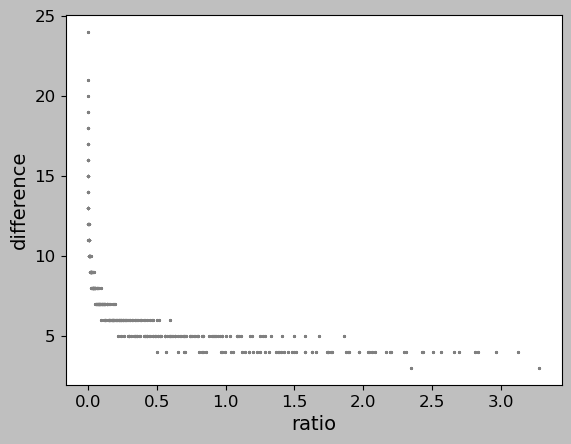

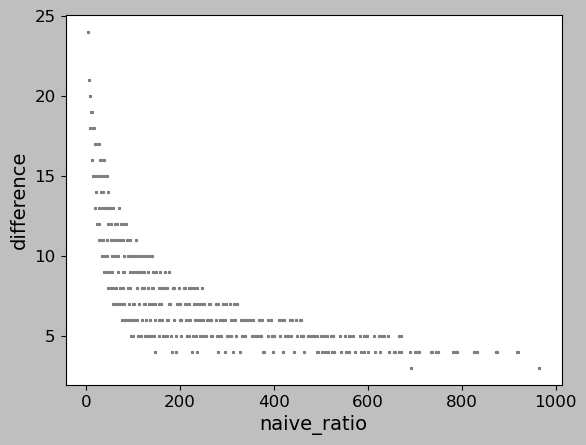

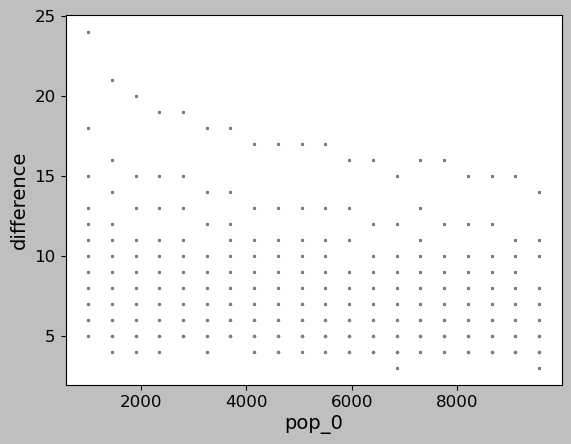

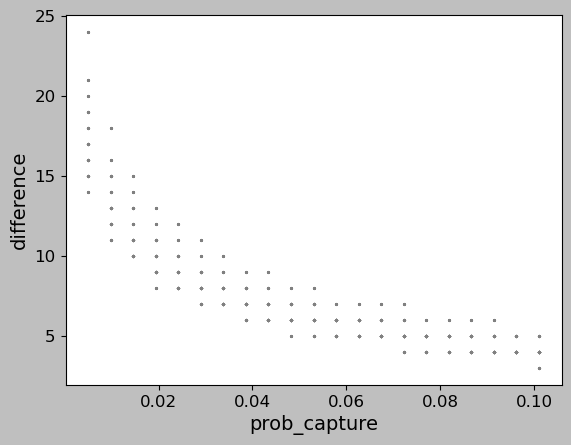

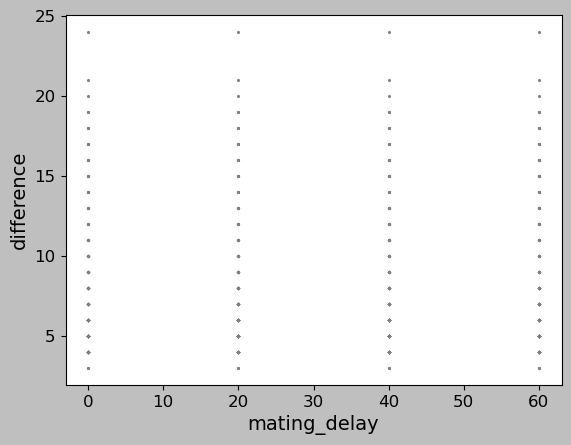

In [5]:
is_log = False
capture_df.plot.scatter(1, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(2, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(3, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(4, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(5, 0, 1.5, loglog=is_log)

## Create function for automatically fitting reciprocal functions using inverse-composition linearization

In [6]:
def autofit_reciprocal(x, y, a_guess, b_guess, c_guess, full_output=False):
    a = a_guess
    b = b_guess
    c = c_guess
    slope = 2
    intercept = 1

    # fit 'b' parameter
    magnitude = 1
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        b_below = b + (0.1 ** magnitude)
        b_above = b - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b_above)), a), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b_below)), a), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        if abs(p[1]) < abs(p_above[1]) and abs(p[1]) < abs(p_below[1]):
            magnitude = magnitude + 1
        elif abs(p_above[1]) < abs(p_below[1]):
            b = b_above
        elif abs(p_below[1]) < abs(p_above[1]):
            b = b_below

    # fit 'a' parameter
    magnitude = 0
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        a_below = a + (0.1 ** magnitude)
        a_above = a - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_above), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_below), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        # print(f'{a}, {p_above[0]}, {p[0]}, {p_below[0]}')
        if abs(p[0] - 1) < abs(p_above[0] - 1) and abs(p[0] - 1) < abs(p_below[0] - 1):
            magnitude = magnitude + 1
        elif abs(p_above[0] - 1) < abs(p_below[0] - 1):
            a = a_above
        elif abs(p_below[0] - 1) < abs(p_above[0] - 1):
            a = a_below
    if full_output:
        return (a, b, p)
    else:
        return (a, b)

## Fit curve to data using naive ratio

0.9999960736764413 6.424741591650025e-13


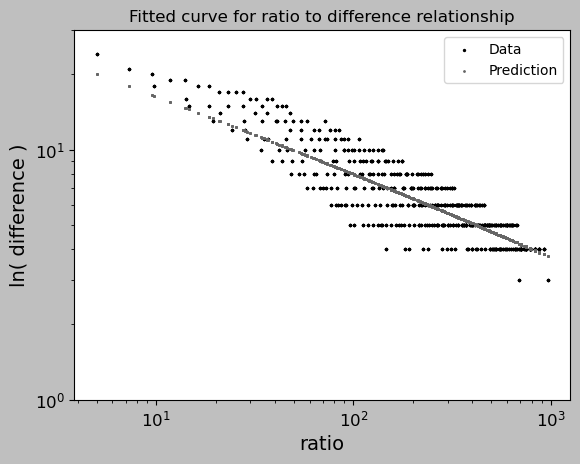

In [7]:
x = capture_df.naive_ratio
y = capture_df.difference

c = 0.29
a, b, p = autofit_reciprocal(x, y, 3, 0.3, c, full_output=True)
print(*p)

y_linear_naive = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y_naive = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y_naive, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()

## Check residuals

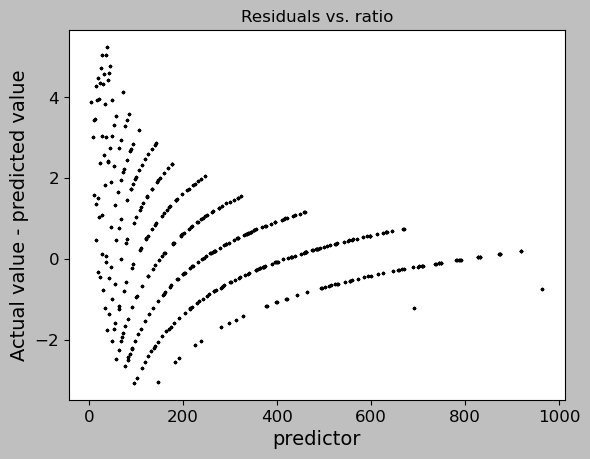

In [8]:
from scipy.stats import zscore

def residual_plot(x, y, fitted_y, log=False):
    data = {'ratio': x, 'residual':np.subtract(y, fitted_y)}
    residuals = pd.DataFrame(data)
    #residuals = residuals[(np.abs(zscore(residuals.residual)) < 4)]
    ax = plt.axes()
    ax.scatter(residuals.ratio, residuals.residual, label='Data', s=2)
    ax.set_title('Residuals vs. ratio')
    ax.set_ylabel('Actual value - predicted value')
    ax.set_xlabel('predictor')
    if log:    
        ax.set_yscale('log')
        ax.set_xscale('log')

residual_plot(x, y, fitted_y_naive)

heteroscedasticity could definitely be improved

## Fit curve to data using smarter ratio

(3.9738545041692013, 0.5230897405853895)


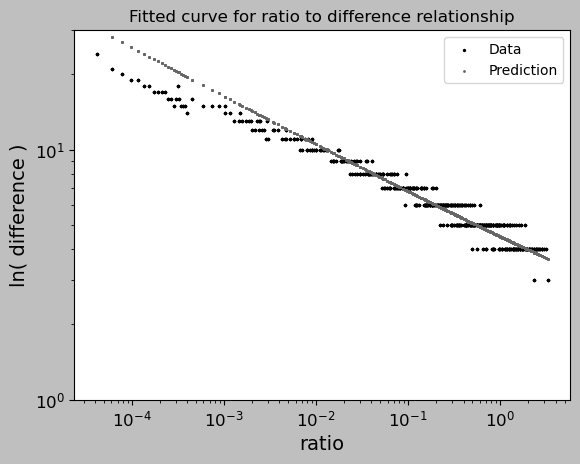

In [9]:
x = capture_df.ratio
y = capture_df.difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

For the ratio function of (pop_0^1/3) * (prob_capture^3), a function of y = (3.024 / x ^ 0.2) + 0.965 predicts the difference in first emergence and first capture.

## Determine goodness of fit by looking at residuals

### Residual Plot

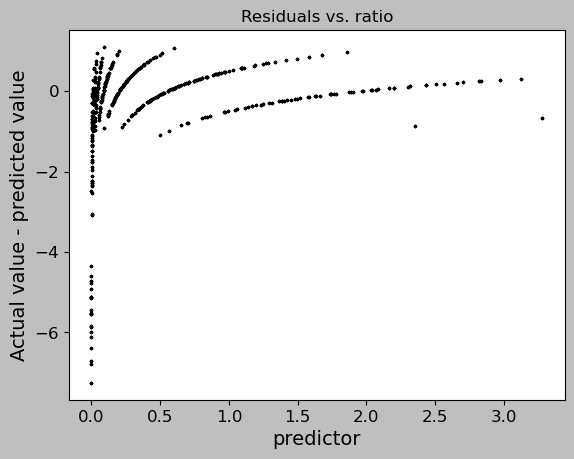

In [10]:
residual_plot(x, y, fitted_y)

Definitely still some heteroscedasticity, but it looks like the worst of it is only +/- 1. Measureable improvement from the naive ratio. Furthermore, from looking at the fitted curve graphs of the two, no value of 'c' was able to match both the extreme and median points to a satisfactory degree with the naive ratio, but a 'c' of 0.2 matches both quite well with the smarter combination

### Average bias per point

In [11]:
np.sum(np.subtract(y, fitted_y)) / len(x)

np.float64(-0.38097613338611624)

The fitted curve is a little biased relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.

## At this point I decide to rethink which parameter I want to base the model off of

My rationale is this: One of the biggest issues I'm facing in making this model is the extreme instability around small ratio values, and if you look at the difference vs predictor graphs I have towards the top, you can visually see that it is mostly the fault of the "size of the overwintering population" (pop_0) to blame for this. Furthermore, this parameter would be _very_ difficult to get an actual read on in the field. Furthermore, if I do analysis on the sampling effort with a constant population, then that allows me to trivially apply these differences to the known phenology curves, which are in proportions of total population and not integer moth counts. If the population is kept constant through the first generation, just multiply the phenology curves by that constant number to apply the differences, and then divide again to get back to proportions. The capture probability parameter is both more uniformly stable around small values, and also is actually feasible to estimate in real world situations, so I'm going to generate a new data set, holding both mating delay and pop_0 constant, so as to get a direct look at the effect of the per degree day capture probability with significantly higher resolution. I also had to modify the data output from the simulation to get an integrated energence value, as the current system for using the population active works explicitly only for the first emergence, as any past that are subject to death and capture diminishing the true number of emergences.

## Build DataFrames for the new focused set

In [12]:
df = pd.read_csv('test_2.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

/usr/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Investigate also how the difference evolves when looking at second captures, third captures, etc.

### Compile 1st through 300th differences

In [13]:
diffs = []
for i in range(1,150):
    row = compile_diffs(dfs, i)
    row_df = pd.DataFrame(row, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
    diffs.append(row_df)

len(diffs)

149

### Look at the graphs of the first, second, third, fifth, and fiftieth differences against the probability of capture

<Axes: title={'center': 'Fiftieth capture difference'}, xlabel='prob_capture', ylabel='difference'>

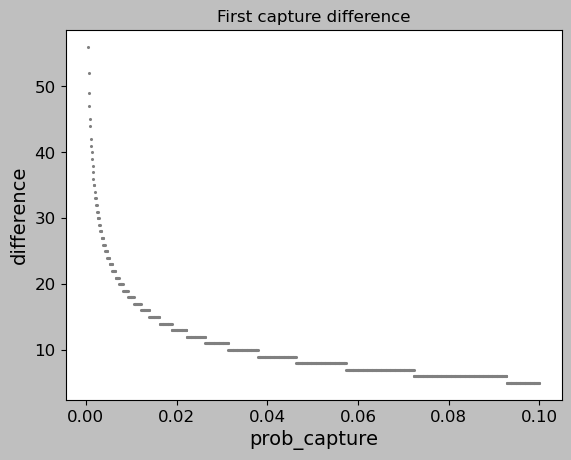

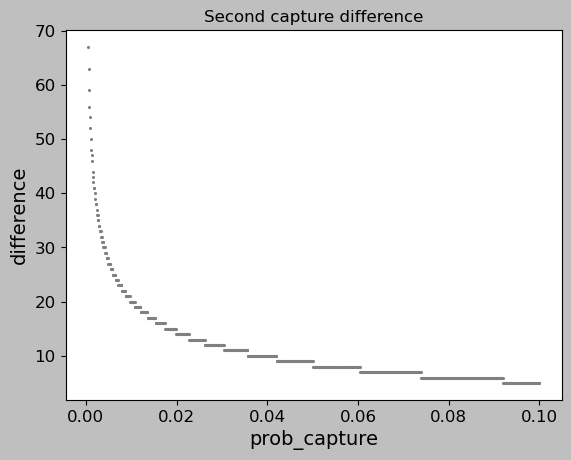

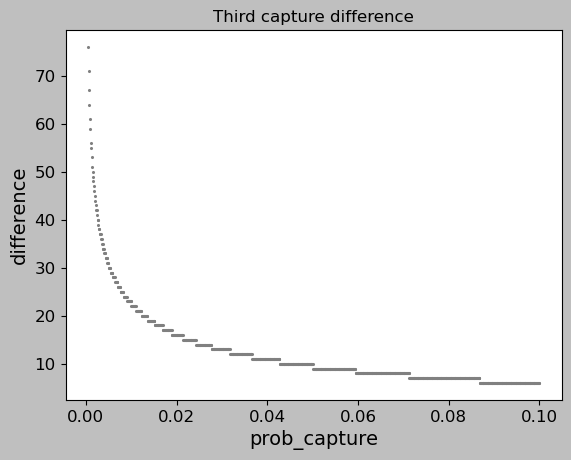

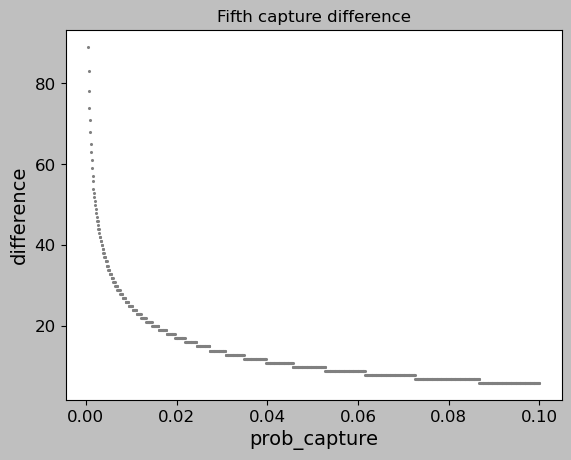

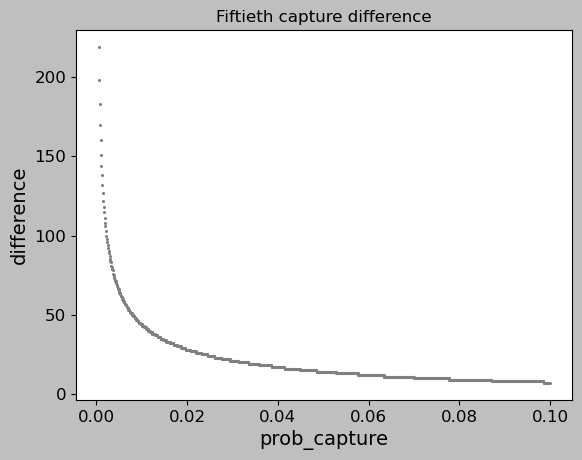

In [14]:
is_log = False
diffs[0].plot.scatter(4, 0, 1.5, title='First capture difference', loglog=is_log)
diffs[1].plot.scatter(4, 0, 1.5, title='Second capture difference', loglog=is_log)
diffs[2].plot.scatter(4, 0, 1.5, title='Third capture difference', loglog=is_log)
diffs[4].plot.scatter(4, 0, 1.5, title='Fifth capture difference', loglog=is_log)
diffs[49].plot.scatter(4, 0, 1.5, title='Fiftieth capture difference', loglog=is_log)

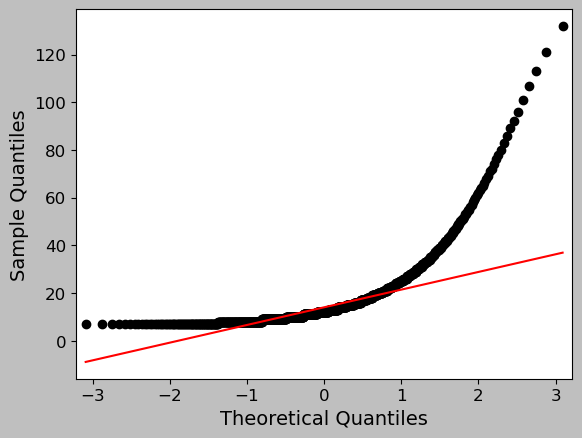

In [15]:
from statsmodels.api import qqplot
_ = qqplot(diffs[14].difference, line='q')

## Make a better fitting function for the more well behaved data

In [16]:
import statsmodels.formula.api as smf

def new_autofit(x, y, residuals=False, full_output=False):
    data = pd.DataFrame({'difference':y, 'prob_capture':x})
    model = smf.ols('np.log(difference) ~ np.log(prob_capture)', data=data).fit()
    if full_output:
        print(model.summary())
    if residuals:
        return (model.params[1], np.exp(model.params[0]), model.resid)
    return (model.params[1], np.exp(model.params[0]))


                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 5.492e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:52:59   Log-Likelihood:                 1148.1
No. Observations:                1000   AIC:                            -2292.
Df Residuals:                     998   BIC:                            -2282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5466 

/tmp/ipykernel_7406/796028987.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]), model.resid)


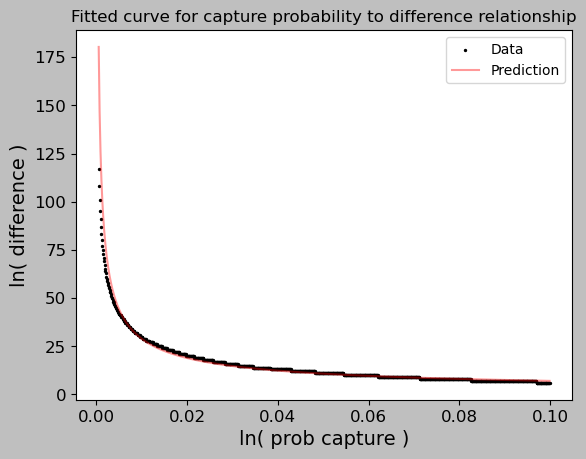

In [17]:
n = 10
x = diffs[n].prob_capture
y = diffs[n].difference

a, b, resid = new_autofit(x, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(x,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for capture probability to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( prob capture )')
ax.legend()

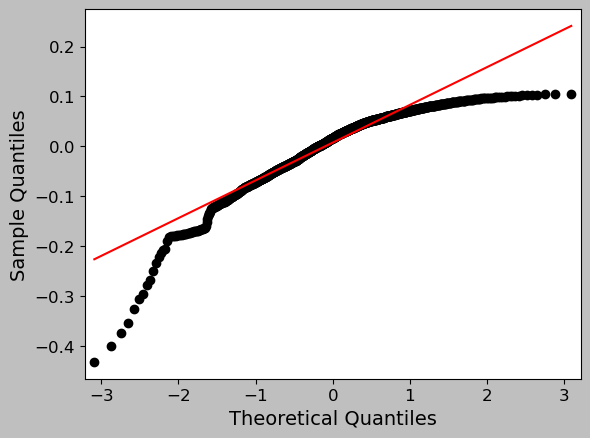

In [18]:
_ = qqplot(resid, line='q')

These residuals aren't perfect but I believe they are well within the realm of acceptability

### Model the change in models!

In [19]:
diffs[1].head()

,difference,ratio,naive_ratio,pop_0,prob_capture,mating_delay
0,67,4.166667e-08,0.5000,1000,0.000500,0
1,63,7.182015e-08,0.5995,1000,0.000599,0
2,59,1.138440e-07,0.6990,1000,0.000699,0
3,56,1.697085e-07,0.7985,1000,0.000798,0
4,54,2.413836e-07,0.8980,1000,0.000898,0


/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: 

1.7424103608885892


/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]))
/tmp/ipykernel_7406/796028987.py:10: 

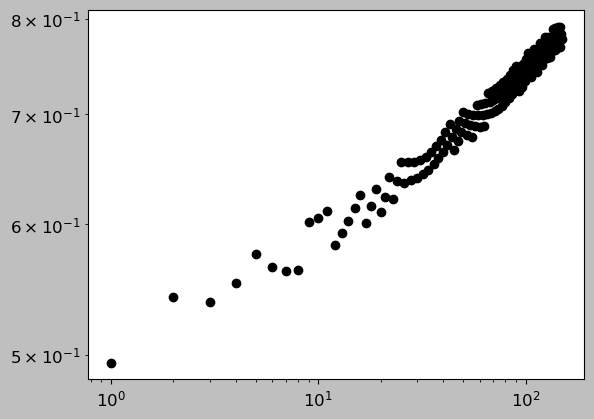

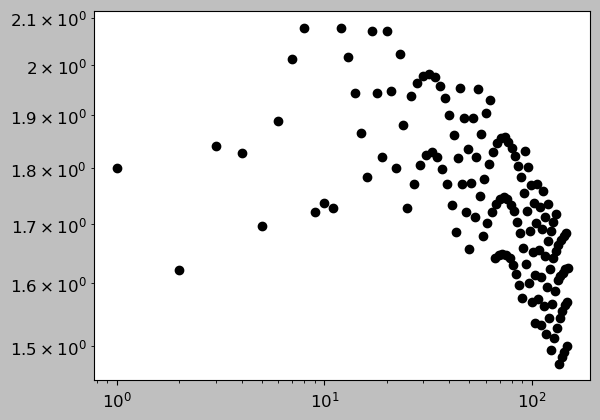

In [20]:
model_mat = []
for diff in diffs:
    a, b = new_autofit(diff.prob_capture, diff.difference)
    model_mat.append((a,b))
    
a = np.array(model_mat).T[0]
a = -a
b = np.array(model_mat).T[1]
x = np.arange(1,len(diffs)+1)

print(np.mean(b))

plt.scatter(x, a)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(x, b)
plt.xscale('log')
plt.yscale('log')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   coef   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     175.0
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           8.32e-27
Time:                        19:53:00   Log-Likelihood:                 139.56
No. Observations:                 149   AIC:                            -275.1
Df Residuals:                     147   BIC:                            -269.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9228      0.016    122.292      0.0

/tmp/ipykernel_7406/4071384533.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_a = model.params[1]
/tmp/ipykernel_7406/4071384533.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_b = model.params[0]


(np.float64(-0.002405655236677143),
 np.float64(1.9228345036393757),
 np.float64(1.7424103608885892))

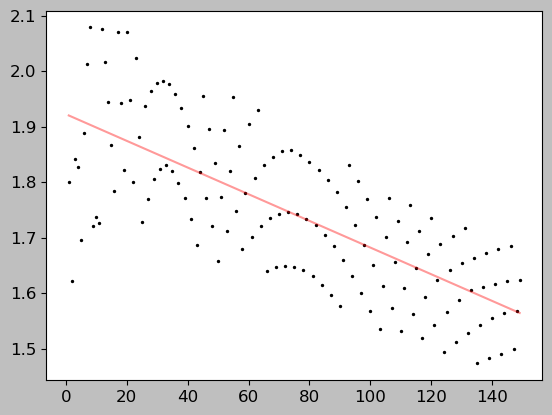

In [21]:
data = pd.DataFrame({'coef':b, 'n_diff':x})
model = smf.ols('coef ~ n_diff', data=data).fit()
b_a = model.params[1]
b_b = model.params[0]
y_fitted = b_b + (b_a*x)
print(model.summary())
ax = plt.axes()
ax.scatter(x, b, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(b_a, b_b, np.mean(b))

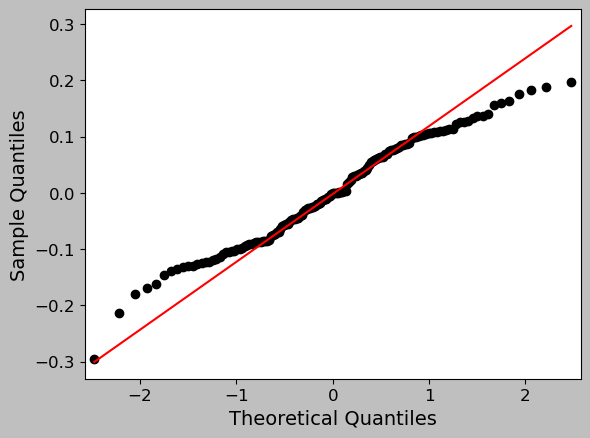

In [22]:
_ = qqplot(model.resid, line='q')

                            OLS Regression Results                            
Dep. Variable:          np.log(power)   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3858.
Date:                Wed, 09 Oct 2024   Prob (F-statistic):          2.14e-107
Time:                        19:53:00   Log-Likelihood:                 385.66
No. Observations:                 149   AIC:                            -767.3
Df Residuals:                     147   BIC:                            -761.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7535      0.007   -114.

/tmp/ipykernel_7406/2330328472.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_a = model.params[1]
/tmp/ipykernel_7406/2330328472.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_b = np.exp(model.params[0])


(np.float64(0.0989563355055343), np.float64(0.4707322693477569))

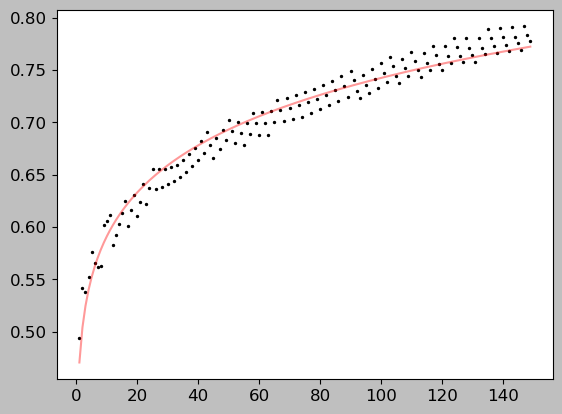

In [23]:
data = pd.DataFrame({'power':a, 'n_diff':x})
model = smf.ols('np.log(power) ~ np.log(n_diff)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
y_fitted = np.multiply(np.power(x,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(x, a, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

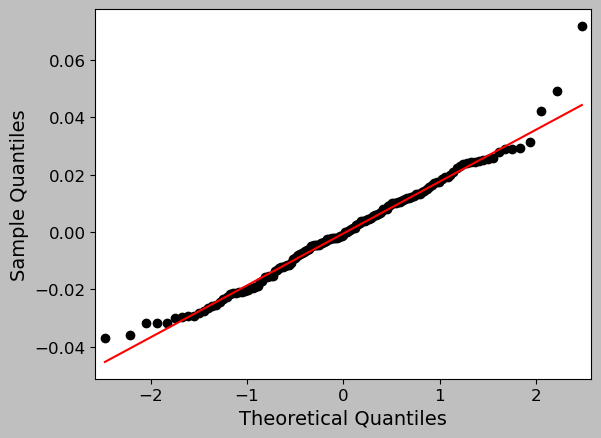

In [24]:
_ = qqplot(model.resid, line='q')

The model for the exponent of the power law is REALLY good, the residuals show that the true distribution may have *ever so slightly* heavier tails than the fitted model, but with such low variance thats something that is totally fine by me.  
The model for the coefficient isn't exactly a perfect fit, but it contributes so little to the overall model that I don't think it's worth the added complexity of making it better. Additionally it would require looking into more data than I already have here, so it's not worth the labor.

### Look at how effort effects the differences

<Axes: >

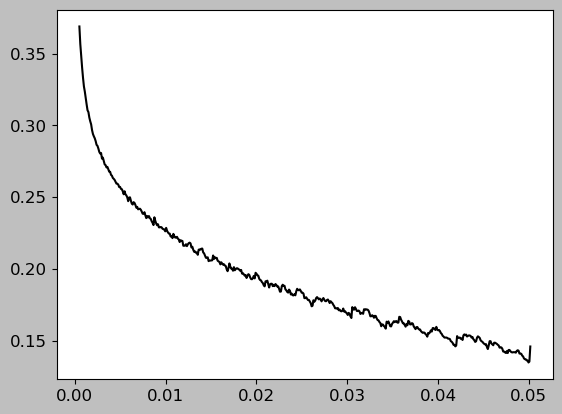

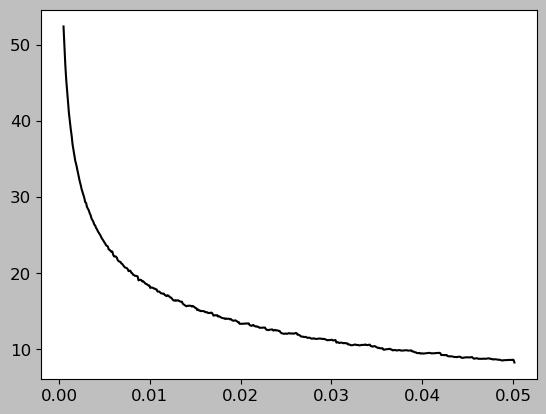

In [25]:
import statsmodels.api as sm
import seaborn as sns
params = []
for m in range(500):
    n = 0
    x = np.arange(1, 80, 1)
    y = [diffs[n].iloc[m].difference for n in x]
    effort = diffs[1].iloc[m].prob_capture
    model = sm.OLS(np.log(y), sm.add_constant(np.log(x))).fit()
    a = model.params[1]
    b = np.exp(model.params[0])
    params.append((effort,a,b))

params = np.array(params)
As = params.T[1]
Bs = params.T[2]
efforts = params.T[0]
plt.figure()
sns.lineplot(x=efforts, y=As)
plt.figure()
sns.lineplot(x=efforts, y=Bs)


                            OLS Regression Results                            
Dep. Variable:          np.log(power)   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.212e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:53:01   Log-Likelihood:                 883.17
No. Observations:                 500   AIC:                            -1762.
Df Residuals:                     498   BIC:                            -1754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5759      0.008   -306.

/tmp/ipykernel_7406/2109910304.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_a = model.params[1]
/tmp/ipykernel_7406/2109910304.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_b = np.exp(model.params[0])


(np.float64(-0.22859199404845806), np.float64(0.0760870693955981))

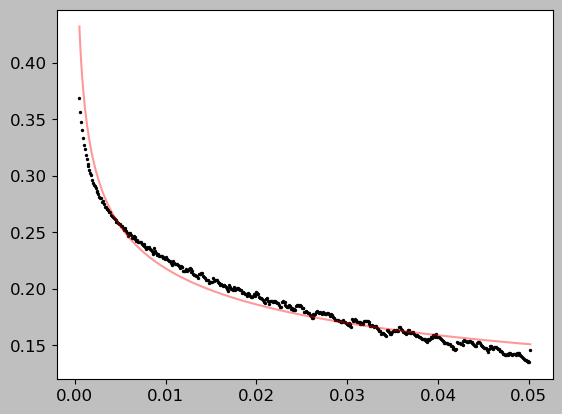

In [26]:
data = pd.DataFrame({'power':As, 'effort':efforts})
model = smf.ols('np.log(power) ~ np.log(effort)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
a_fitted = np.multiply(np.power(efforts,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(efforts, As, label='Data', s=2)
ax.plot(efforts, a_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

                            OLS Regression Results                            
Dep. Variable:           np.log(coef)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 6.467e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:53:01   Log-Likelihood:                 988.79
No. Observations:                 500   AIC:                            -1974.
Df Residuals:                     498   BIC:                            -1965.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9045      0.007    132.

/tmp/ipykernel_7406/261014362.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_a = model.params[1]
/tmp/ipykernel_7406/261014362.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_b = np.exp(model.params[0])


(np.float64(-0.427498938454142), np.float64(2.470626064112154))

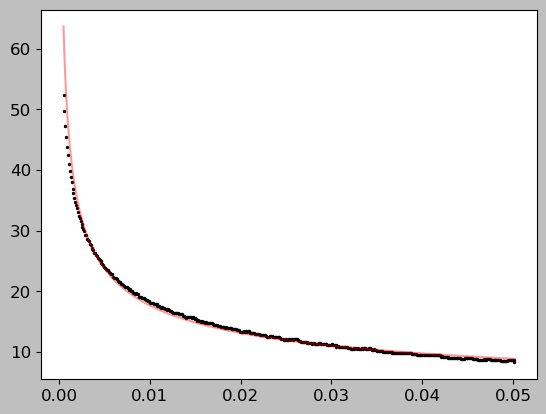

In [27]:
data = pd.DataFrame({'coef':Bs, 'effort':efforts})
model = smf.ols('np.log(coef) ~ np.log(effort)', data=data).fit()
b_a = model.params[1]
b_b = np.exp(model.params[0])
b_fitted = np.multiply(np.power(efforts,b_a), b_b)
print(model.summary())
ax = plt.axes()
ax.scatter(efforts, Bs, label='Data', s=2)
ax.plot(efforts, b_fitted, label='Prediction', alpha=0.4, color='red')
(b_a, b_b)

### Fit johnson su distributions for the efforts

0.0999005000000015


(np.float64(-4.69387644611815), np.float64(2.5676166588388796))

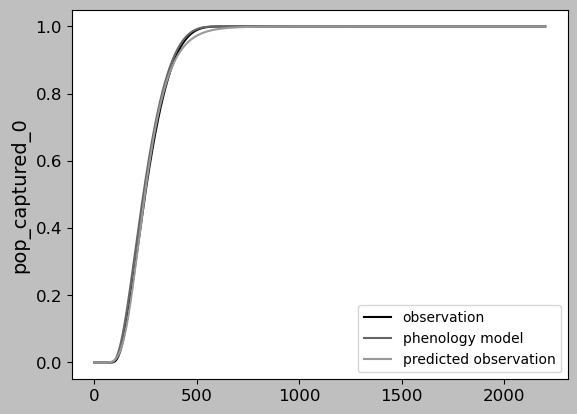

In [28]:
import scipy.stats as sps
import scipy.optimize as spop
from scipy.stats import johnsonsb
from scipy.stats import johnsonsu
import seaborn as sns

n = 999
x_opt = np.arange(0,dfs[n].dd.max()+1,1)
y_opt = dfs[n].pop_captured_0 / 1000
f = lambda dd, gamma, delta: johnsonsu.cdf(dd, gamma, delta, loc=27.5, scale=72.31)
#[-4.8689+(0.3*n),2.0689+(0.06*n),27.503-(7*n),72.3-(3.75*n)]
gamma, delta = spop.curve_fit(f,x_opt,y_opt,p0=[-7.08,  2.29])[0]
y_pred = johnsonsu.cdf(x_opt,gamma, delta, loc=27.5, scale=72.31)
sns.lineplot(x=x_opt, y=y_opt, label='observation')
sns.lineplot(x=x_opt, y=dfs[n].pop_emerged_0/1000, label='phenology model')
sns.lineplot(x=x_opt, y=y_pred, label='predicted observation')
print(dfs[n].head(1).prob_capture.item())
gamma, delta

In [29]:
f = lambda dd, gamma, delta: johnsonsu.cdf(dd, gamma, delta, loc=27.5, scale=72.31)

params = []
for n in range(1000):
    x_opt = np.arange(0,dfs[n].dd.max()+1,1)
    y_opt = dfs[n].pop_captured_0 / 1000
    effort = dfs[n].head(1).prob_capture.item()
    gamma, delta = spop.curve_fit(f,x_opt,y_opt,p0=[-7.08,  2.29])[0]
    params.append((gamma, delta, effort))
    

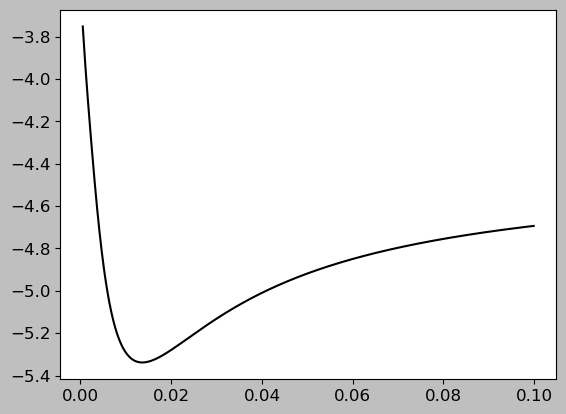

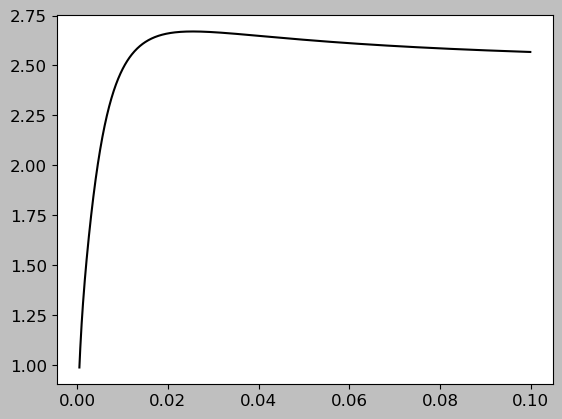

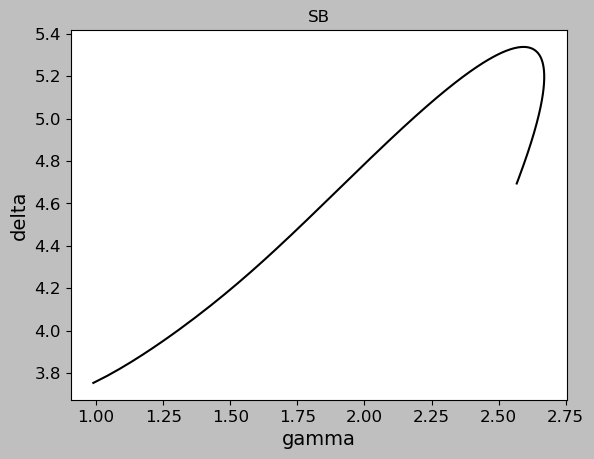

In [30]:
params = np.array(params).T
gammas = params[0]
deltas = params[1]
efforts = params[2]

plt.plot(efforts,gammas)
plt.figure()
plt.plot(efforts,deltas)
plt.figure()
plt.title('SB')
plt.xlabel('gamma')
plt.ylabel('delta')
plt.plot(deltas,-gammas)

#### fit functions for these relationships

-3251828915.427764 -29494386.634669527 -72669.5073246605 740.4344563059263 -3.581945353194297 738165660.7315745 1360371.4216180712 56907.26626775667 -306.2510492876186
-4.436820286359018


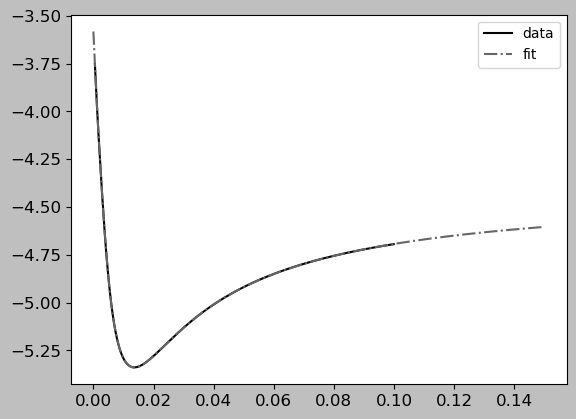

In [31]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rationaln_n(x, p0, p1, p2, p3, p4, q1, q2, q3, q4):
    return rational(x, [p0, p1, p2, p3, p4], [q1, q2, q3, q4])
popt_gammas_su, pcov_gammas_su = spop.curve_fit(rationaln_n, efforts, gammas)

effortspaced = np.linspace(0,0.15,10000)

plt.plot(efforts, gammas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_gammas_su), label='fit', linestyle='-.')
plt.legend()
print(*popt_gammas_su)
print(rationaln_n(1, *popt_gammas_su))

1547130778.812226 -11245546.619027564 -466614.6942582969 -442.5232425234668 0.8521002984014721 628826757.7638363 -7875051.791039231 -83165.24056761258 -964.3410129443149
2.4730203858919046


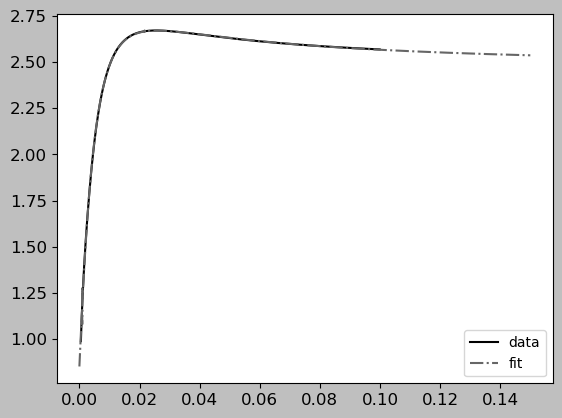

In [32]:
popt_deltas_su, pcov_deltas_su = spop.curve_fit(rationaln_n, efforts, deltas,p0=[1,1,1,1,1000,-1,1,1,-1000])

plt.plot(efforts, deltas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_deltas_su), label='fit', linestyle='-.')
plt.legend()
print(*popt_deltas_su)
print(rationaln_n(1, *popt_deltas_su))

### fit johnson sb distributions for the efforts

In [2]:
import scipy.stats as sps
import scipy.optimize as spop
from scipy.stats import johnsonsb

n = 10
x_opt = np.arange(0,dfs[n].dd.max()+1,1)
y_opt = dfs[n].pop_captured_0 / 1000
loc = 69
f = lambda dd, gamma, delta, xi: johnsonsb.cdf(dd, gamma, delta, loc=loc, scale=xi)
#[-4.8689+(0.3*n),2.0689+(0.06*n),27.503-(7*n),72.3-(3.75*n)]
gamma, delta, xi = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
y_pred = johnsonsb.cdf(x_opt,gamma, delta, loc=loc, scale=xi)
effort = dfs[n].head(1).prob_capture.item()
sns.lineplot(x=x_opt, y=y_opt, label=f'simulated capture\n(efficiency = {round(effort,5)})')
sns.lineplot(x=x_opt, y=dfs[n].pop_emerged_0/1000, label='phenology model\n')
sns.lineplot(x=x_opt, y=y_pred, label=f'Fitted Johnson-SB\n gamma={round(gamma,2)}\n delta={round(delta,2)}\n lambda={round(xi,2)}', linestyle=':',color='red')
plt.xlabel('degree days')
plt.ylabel('proportional moth capture')
gamma, delta, xi

NameError: name 'np' is not defined

#### model the way the the capture diverges from the phenology model

In [34]:
f = lambda dd, gamma, delta, llambda: johnsonsb.cdf(dd, gamma, delta, loc=69, scale=llambda)
params = []
for n in range(1000):
    x_opt = np.arange(0,dfs[n].dd.max()+1,1)
    y_opt = dfs[n].pop_captured_0 / 1000
    effort = dfs[n].head(1).prob_capture.item()
    gamma, delta, llambda = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
    params.append((gamma, delta, llambda, effort))

params = np.array(params).T
gammas = params[0]
deltas = params[1]
lambdas = params[2]
efforts = params[3]

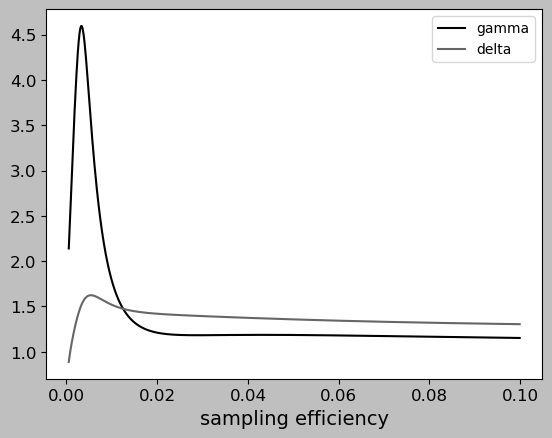

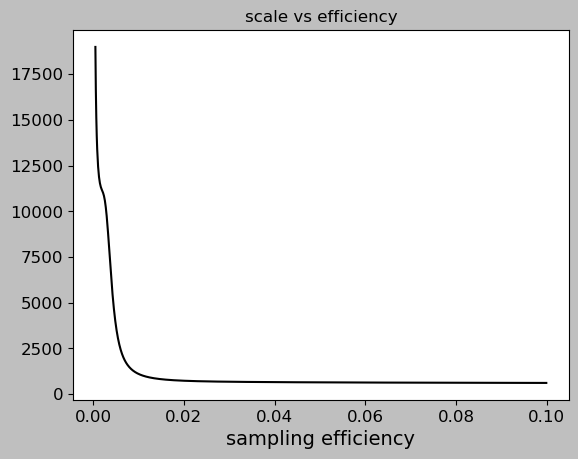

In [35]:
plt.xlabel('sampling efficiency')
sns.lineplot(x=efforts,y=gammas, label='gamma')
sns.lineplot(x=efforts,y=deltas, label='delta')
plt.savefig('gamma_delta_data.pdf')
plt.figure()
plt.title('scale vs efficiency')
plt.xlabel('sampling efficiency')
plt.plot(efforts,lambdas, label='xi)

126265465.59684286 736221.8959032695 13332.256952405249 334.65989977530245 1.6984372693520218 120413098.30657667 -924004.5893391584 65919.69529005302 -317.1106469632625
1.0624037279548832
[3.43753718e+06 1.30762014e+05 1.08819103e+03 8.11930989e+00
 3.21487520e-03 2.96211938e+06 1.08728174e+05 6.66635208e+02
 2.16243665e+00]


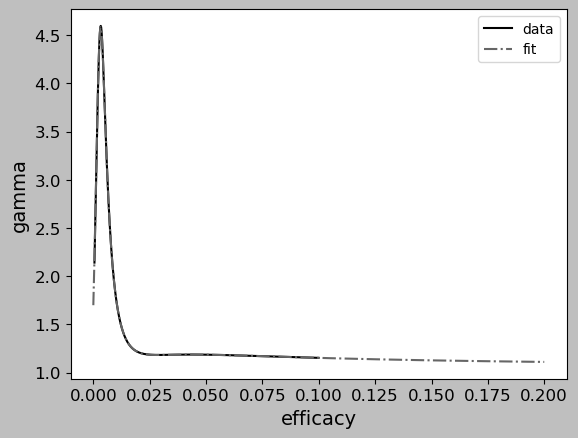

In [36]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rationaln_n(x, p0, p1, p2, p3, p4, q1, q2, q3, q4):
    return rational(x, [p0, p1, p2, p3, p4], [q1, q2, q3, q4])
effortspaced = np.linspace(0,0.2,5000)

popt_gammas, pcov_gammas = spop.curve_fit(rationaln_n, efforts, gammas)
plt.plot(efforts, gammas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_gammas), label='fit', linestyle='-.')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('gamma')
print(*popt_gammas)
(print(rationaln_n(1, *popt_gammas)))
print(np.sqrt(np.diag(pcov_gammas)))

202079171.49474132 7736313.043943313 -34506.41893521196 437.6382625137539 0.7130542737774402 168914955.90812212 4317538.170333093 -1401.9548045371614 64.43123694540152
1.2109912525672397
[1.68174999e+06 1.77197620e+05 1.30106186e+03 4.69483619e+00
 1.19703636e-03 1.34716933e+06 1.26049009e+05 9.49504988e+02
 3.09137999e+00]


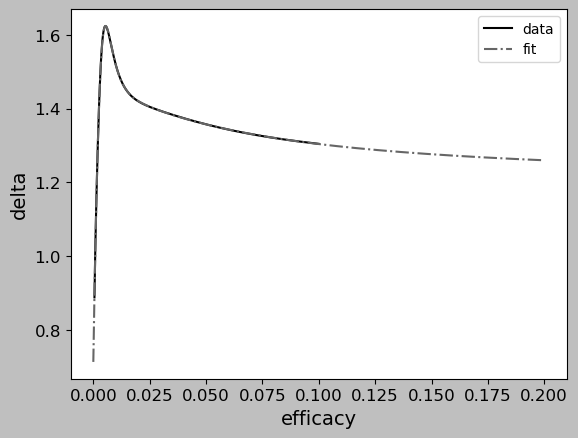

In [37]:
popt_deltas, pcov_deltas = spop.curve_fit(rationaln_n, efforts, deltas)

plt.plot(efforts, deltas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_deltas), label='fit', linestyle='-.')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('delta')
print(*popt_deltas)
(print(rationaln_n(1, *popt_deltas)))
print(np.sqrt(np.diag(pcov_deltas)))

0.44119796355389007
1.1493792602851443
35.110340180075916
0.0022809509065793983
0.0011045156276954628
[7.91980428e-03 2.34615621e-03 1.42410805e-01 5.00415608e-06
 3.40698358e-06]


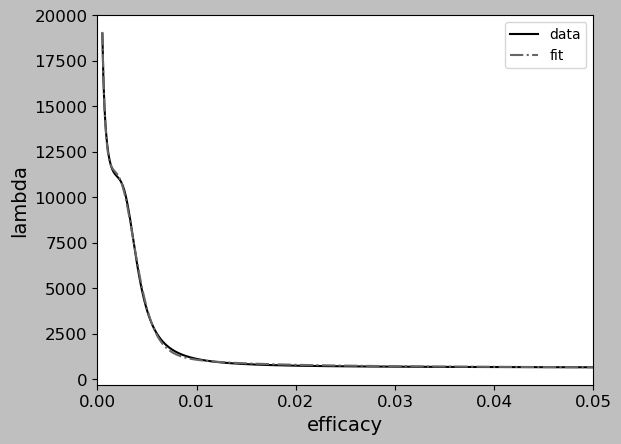

In [38]:
from scipy.stats import logistic

f_lambda = lambda x, b_0, b_1, b_2, b_3, b_4: np.reciprocal(b_0 * (x ** b_1)) + 577 + (b_2 * logistic.pdf(x, loc=b_3, scale=b_4)) 
effortspaced_lambda = np.linspace(0.0005,0.1,5000)
popt_lambdas, pcov_lambdas = spop.curve_fit(f_lambda, efforts, lambdas, p0=[2.5, 1.5, 40, 0.00225, 0.0013])
#popt_lambdas = [2.5, 1.5, 5000, 0.0025, 0.0013]
plt.plot(efforts, lambdas, label='data')
plt.plot(effortspaced_lambda, f_lambda(effortspaced_lambda, *popt_lambdas), label='fit', linestyle='-.')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('lambda')
plt.xlim(0,0.05)
for coef in popt_lambdas:
    print(coef)
print(np.sqrt(np.diag(pcov_lambdas)))

### Shifting emergence data to meet capture data

In [39]:
def capture_prediction_su(dd, effort, max):
    gamma = rationaln_n(effort, *popt_gammas_su)
    delta = rationaln_n(effort, *popt_deltas_su)
    xi = 27.5
    llambda = 72.31
    return max * johnsonsu.cdf(dd, gamma, delta, loc=xi, scale=llambda)

def capture_prediction_sb(dd, effort, max, print_coef=False):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    xi = 69
    if print_coef:
        print(f'{gamma}, {delta}, {llambda}')
    return max * johnsonsb.cdf(dd, gamma, delta, loc=xi, scale=llambda)

def capture_prediction_sb_mean(effort):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    xi = 69
    return johnsonsb.moment(1,gamma, delta, loc=xi, scale=llambda)

def jw_emergence(dd, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return max * johnsonsb.cdf(dd, gamma, delta, loc=zeta, scale=llambda)
def inv_jw_emergence(moths, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return johnsonsb.ppf((moths/max), gamma, delta, loc=zeta, scale=llambda)

0.00249

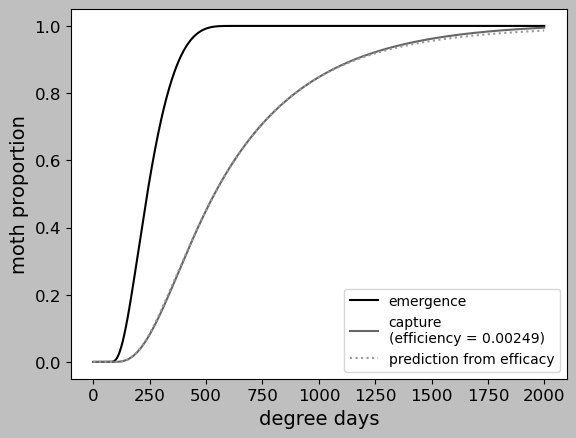

In [40]:
shift_data = dfs[20]
x = shift_data.dd
y_emerge = shift_data.pop_emerged_0
y_capture = shift_data.pop_captured_0
effort = shift_data.head(1).prob_capture.item()
max_time = 2000

y_max = y_capture.max()
func_adj_y = capture_prediction_sb(x, effort, 1000)
ax = sns.lineplot(x=x[0:max_time], y=y_emerge[0:max_time]/1000, label='emergence')
ax = sns.lineplot(x=x[0:max_time], y=y_capture[0:max_time]/np.max(y_capture), label=f'capture\n(efficiency = {round(effort,5)})')
ax = sns.lineplot(x=x[0:max_time], y=func_adj_y[0:max_time]/1000, label='prediction from efficacy', linestyle=':')
ax.set(xlabel='degree days', ylabel='moth proportion')
effort

## Analysis of Field Data

### Data prep and looks at dd~diff slices

In [41]:
oksir = pd.read_csv('region_A1a.csv')
oksir.head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [42]:
years = oksir.Year.unique()
oksir_year = {}
for year in years:
    oksir_year[year] = oksir[oksir['Year'] == year]
oksir_year[2015].head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [43]:
def num_traps(data):
    return len(data.X.unique())

At this point I realize that I need to combine this very granular dataset with an integrated one I also have. Only issue is that it doesn't have year information. I need to use the first date and the first capture date to match them together.

In [44]:
years

array([2015, 2014, 2004, 1998, 2009, 2001, 2007, 2013, 2000, 2002, 1995,
       1996, 1999, 2006, 2008, 2010, 2005, 1997, 2012, 2011])

In [45]:
year_jul = []
for year in years:
    year_jul.append((year, \
                     oksir_year[year].head(1).julian.item(), \
                     oksir_year[year][oksir_year[year]['Wild'] > 0.9].head(1).julian.item()))
year_jul
years_table = pd.DataFrame(columns=['year','first_julian','first_capture_julian'], data=year_jul)
years_table

,year,first_julian,first_capture_julian
0,2015,103,119
1,2014,105,126
2,2004,109,116
3,1998,110,117
4,2009,110,132
5,2001,112,133
6,2007,114,120
7,2013,114,133
8,2000,115,115
9,2002,119,133


In [46]:
data_agg = pd.read_csv('region_A1a_aggregated.csv')
data_agg.head()

,Unnamed: 0,julian,moths,var,traps,pr0,DDs,trap_group
0,1,121,1.784615,11.178056,130,0.000000,198.993791,1
1,2,128,7.198473,90.452613,131,0.000000,253.448087,1
2,3,135,9.598485,122.211601,132,0.051529,328.473335,1
3,4,142,8.946970,106.020067,132,0.000000,413.464368,1
4,5,149,4.098485,32.394807,132,0.000000,527.562890,1


In [47]:
data_agg['moths_whole'] = data_agg['moths'] * data_agg['traps']
data_agg = data_agg.drop(columns=['Unnamed: 0'])

In [48]:
data_agg.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole
0,121,1.784615,11.178056,130,0.000000,198.993791,1,232.0
1,128,7.198473,90.452613,131,0.000000,253.448087,1,943.0
2,135,9.598485,122.211601,132,0.051529,328.473335,1,1267.0
3,142,8.946970,106.020067,132,0.000000,413.464368,1,1181.0
4,149,4.098485,32.394807,132,0.000000,527.562890,1,541.0


In [49]:
years_table_unique = years_table.drop_duplicates(subset=['first_julian', 'first_capture_julian'], keep=False) 
group_year_lut = np.zeros(20)
for group in range(len(group_year_lut)):
    first = years_table_unique['first_julian']
    capture = years_table_unique['first_capture_julian']
    agg_grouped = data_agg[data_agg['trap_group'] == group + 1]
    agg_first = agg_grouped.head(1).julian.item()
    agg_capture = agg_grouped[agg_grouped['moths'] > 0].head(1).julian.item()
    year_table_row = years_table_unique[(first == agg_first) & (capture == agg_capture)]
    if len(year_table_row) == 0:
        group_year_lut[group] = None
    else:
        group_year_lut[group] = year_table_row.year.item()

print(group_year_lut)

[  nan   nan 1997. 1998.   nan 2000. 2001. 2002. 2004. 2005.   nan 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]


In [50]:
data_agg['year'] = data_agg.trap_group.apply(lambda x: group_year_lut[x-1])
data_agg_clean = data_agg.dropna()

In [51]:
data_agg_clean.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year
38,126,0.145078,0.176759,193,0.636875,185.932829,3,28.0,1997.0
39,133,0.589474,2.814703,190,0.000000,278.701708,3,112.0,1997.0
40,140,1.520408,13.409838,196,0.000000,378.042837,3,298.0,1997.0
41,147,0.807107,8.564643,197,0.000000,449.430991,3,159.0,1997.0
42,154,1.137056,7.098467,197,0.000000,545.636534,3,224.0,1997.0


In [52]:
# Split frame into array of frames by year
aggs = [y for x, y in data_agg_clean.groupby('year')]
aggs[0].head()

del aggs[14] #only 15 moths captured, sample size not large enough to be useful

In [53]:
for frame in aggs:
    frame['moth_sum'] = frame['moths_whole'].cumsum()

aggs[4].head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year,moth_sum
145,119,0.000000,0.000000,115,1.000000,167.020556,8,0.0,2002.0,0.0
146,126,0.000000,0.000000,115,1.000000,210.531834,8,0.0,2002.0,0.0
147,133,0.051724,0.066867,116,0.859668,257.774916,8,6.0,2002.0,6.0
148,140,0.153846,0.320955,117,0.736026,322.765675,8,18.0,2002.0,24.0
149,147,0.084746,0.146603,118,0.840004,384.749418,8,10.0,2002.0,34.0


#### Extract first differences from data

In [54]:
diffs_field = []
for i in range(25):
    acc = []
    for frame in aggs:
        first_capture_row = frame[(frame['moth_sum'] > 5*i)].head(1)
        first_emergence = inv_jw_emergence(5*i, frame.moth_sum.max())
        if len(first_capture_row) == 0:
            continue
        first_capture = first_capture_row.DDs.item()
        traps = num_traps(oksir_year[int(first_capture_row.year.item())])
        acc.append((traps, first_capture - first_emergence))
    diffs_field.append(np.array(acc).T)
diffs_field[0]

array([[197.        , 199.        , 396.        , 390.        ,
        123.        , 370.        , 365.        , 320.        ,
        298.        , 271.        , 265.        , 262.        ,
        254.        , 253.        , 249.        ],
       [116.9328289 , 109.14993695, 123.47041156, 212.662073  ,
        188.77491637, 176.30079665, 216.57554165, 154.10404756,
         55.48364563, 145.62099489, 141.82771364,  76.22034197,
        199.82825051, 300.88024319, 195.39448517]])

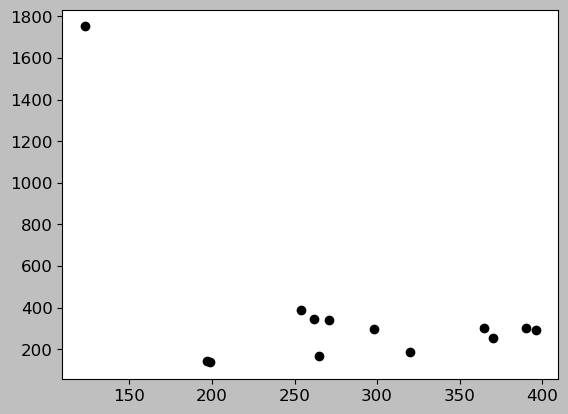

In [55]:
plt.scatter(diffs_field[20][0], diffs_field[20][1])

                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     4.495
Date:                Wed, 09 Oct 2024   Prob (F-statistic):             0.0600
Time:                        19:53:09   Log-Likelihood:                -8.5857
No. Observations:                  12   AIC:                             21.17
Df Residuals:                      10   BIC:                             22.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.9162 

/usr/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/tmp/ipykernel_7406/796028987.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (model.params[1], np.exp(model.params[0]), model.resid)


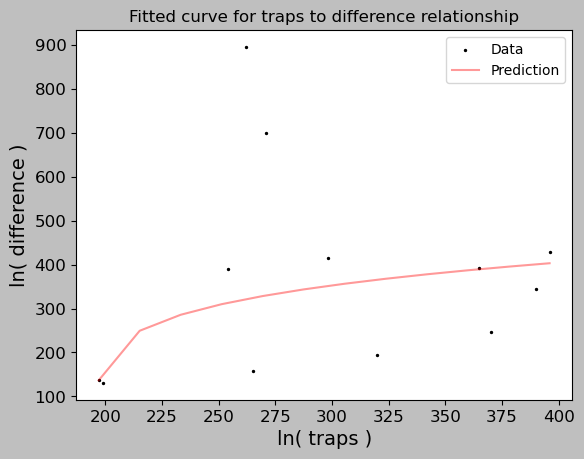

In [56]:
n = 24
x = diffs_field[n][0]
y = diffs_field[n][1]
a, b, resid = new_autofit(x-x.min()+1, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(fitted_x-x.min()+1,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(fitted_x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for traps to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( traps )')
ax.legend()

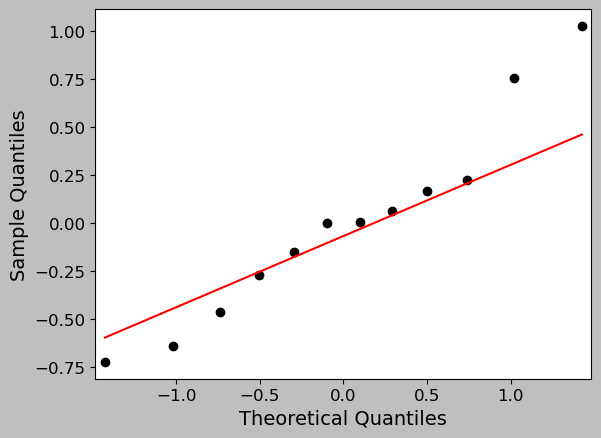

In [57]:
_ = qqplot(resid, line='q')

### Capture curve predictions on field data

In [58]:
len(years)

20

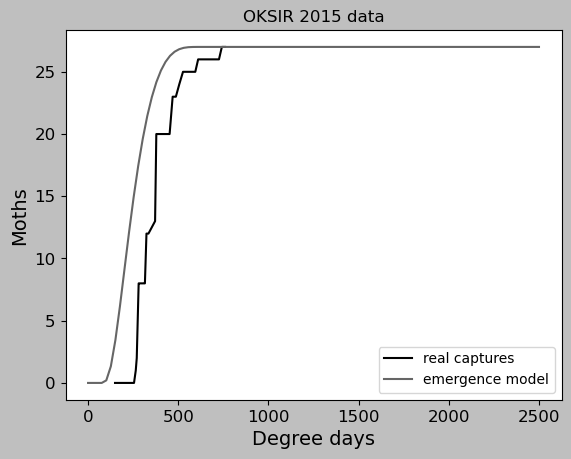

In [59]:
n = 14
phenology_x = np.linspace(0,2500, 100)
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
capture_x = capture_x[capture_x < 800]
capture_y = capture_y[:len(capture_x)]
y_max = aggs[n][aggs[n].DDs < 800].moth_sum.max()
phenology_y = [jw_emergence(x, y_max) for x in phenology_x]
adj_y = capture_prediction_sb(phenology_x, 0.0025, y_max)
ax = plt.title(f'OKSIR {int(aggs[n].head(1).year.item())} data')
ax = plt.xlabel('Degree days')
ax = plt.ylabel('Moths')
ax = sns.lineplot(x=capture_x, y=capture_y, label='real captures')
ax = sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
#sns.lineplot(x=phenology_x, y=adj_y, label='predicted capture')
#sns.lineplot(x=capture_x, y=adj_y, label='predicted capture')

### Prediction training for real-world use

0.003891551874291824
28.999999999999993


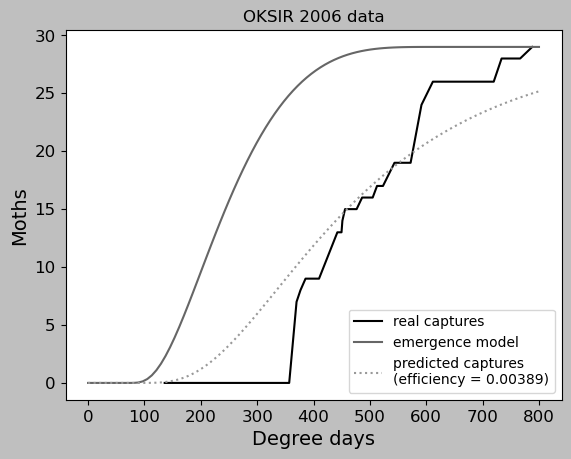

In [60]:
from scipy.stats.distributions import t
def predict_from_subset(dds, captures, CI=False):
    f = lambda dd, effort, max: capture_prediction_sb(dd, effort, max)
    params, pcov = spop.curve_fit(f,dds,captures,p0=[0.005,  500])
    effort, max = params
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        effort_CI = (effort - S[0]*tval, effort + S[0]*tval)
        max_CI = (max - S[1]*tval, max + S[1]*tval)
        return (effort, max, effort_CI, max_CI)
    return  (effort, max)
def predict_max(dds, captures, effort, CI=False):
    f = lambda dd, max: capture_prediction_sb(dd, effort, max)
    params, pcov = spop.curve_fit(f,dds,captures,p0=[500])
    max = params[0]
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        max_CI = (max - S[0]*tval, max + S[0]*tval)
        return (max, max_CI)
    return max
def predict_from_full(dds, captures, CI=False):
    f = lambda dd, effort: capture_prediction_sb(dd, effort, np.max(captures))
    params, pcov = spop.curve_fit(f,dds,captures,p0=[0.005])
    effort = params[0]
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        effort_CI = (effort - S[0]*tval, effort + S[0]*tval)
        return (effort, effort_CI)
    return effort
def predict_from_proportions(dds, captures, CI=False):
    f = lambda dd, effort: capture_prediction_sb(dd, effort, 1)
    params, pcov = spop.curve_fit(f,dds,captures,p0=[0.005])
    effort = params
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        effort_CI = (effort - S[0]*tval, effort + S[0]*tval)
        return (effort, effort_CI)
    return  effort

n = 13
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
capture_x = capture_x[capture_x < 800]
capture_y = capture_y[:len(capture_x)]
limit = capture_x.tail(1).item()*0.2
obs_x = capture_x[capture_x < limit]
obs_y = capture_y[:len(obs_x)]
effort_pred = predict_from_full(capture_x, capture_y)
#effort_pred_lim, max_pred_lim = predict_from_subset(obs_x, obs_y)
print(effort_pred)
#print((effort_pred_lim, max_pred_lim))
phenology_x = np.linspace(0,800, 100)
true_max = capture_y.tail(1).item()
phenology_y = [jw_emergence(x, true_max) for x in phenology_x]
adj_y = capture_prediction_sb(phenology_x, effort_pred, true_max)
#adj_y_lim = capture_prediction_sb(phenology_x, effort_pred_lim, max_pred_lim)
ax = plt.title(f'OKSIR {years[n]} data')
plt.xlabel('Degree days')
plt.ylabel('Moths')
sns.lineplot(x=capture_x, y=capture_y, label='real captures')
sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
sns.lineplot(x=phenology_x, y=adj_y, label=f'predicted captures\n(efficiency = {round(effort_pred,5)})', linestyle=':')
# sns.lineplot(x=phenology_x, y=adj_y_lim, label=f'limited predicted captures\n(efficiency = {effort_pred_lim.round(5)})', linestyle='-.') 
print(capture_y.tail(1).item())

In [61]:
n = 13
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
capture_x = capture_x[capture_x < 685]
capture_y = capture_y[:len(capture_x)]
limit = capture_x.tail(1).item()*0.5
obs_x = capture_x[capture_x < limit]
obs_y = capture_y[:len(obs_x)]
print(len(obs_x))
max, max_CI = predict_max(obs_x, obs_y, 0.00437, CI=True)
print(f'{max}, [{max_CI[0]},{max_CI[1]}], {np.max(capture_x)}')


12
-5e-324, [-5e-324,-5e-324], 680.929965770524


In [62]:
def prediction_jkkn(dds, captures):
    results = []
    for i in range(len(dds)-1):
        x = np.concatenate((dds[:i],dds[i+1:]))
        y = np.concatenate((captures[:i],captures[i+1:]))
        eff, max, eff_CI, max_CI = predict_from_subset(x, y, CI=True)
        eff_low, eff_high = eff_CI
        max_low, max_high = max_CI
        results.append((eff,eff_low,eff_high,max,max_low,max_high))
    results = np.array(results)
    results_avg = np.mean(results.T,axis=1)
    print(results_avg)

prediction_jkkn(obs_x, obs_y)

[5.00000012e-03 5.00000011e-03 5.00000012e-03 8.70713644e-23
 6.74777044e-23 1.06665024e-22]


In [63]:
import statsmodels.api as sm

effort_traps = []
for n, agg in enumerate(aggs):
    capture_x = aggs[n].DDs
    capture_y = aggs[n].moth_sum
    capture_x = capture_x[capture_x < 800]
    capture_y = capture_y[:len(capture_x)]
    limit = capture_x.tail(1).item()*0.5
    obs_x = capture_x[capture_x < limit]
    obs_y = capture_y[:len(obs_x)]
    effort_pred_loop = predict_from_full(capture_x, capture_y)
    effort_pred_loop_lim, _ = predict_from_subset(obs_x, obs_y)
    traps_loop = num_traps(oksir_year[years[n]])
    if np.abs(1 - (effort_pred_loop_lim/effort_pred_loop)) >= 1:
        effort_traps.append((effort_pred_loop_lim, traps_loop))
    else:
        effort_traps.append((effort_pred_loop, traps_loop))

effort_traps = np.array(effort_traps).T
effort_traps[0]

/tmp/ipykernel_7406/907096657.py:3: RuntimeWarning: invalid value encountered in scalar power
  f_lambda = lambda x, b_0, b_1, b_2, b_3, b_4: np.reciprocal(b_0 * (x ** b_1)) + 577 + (b_2 * logistic.pdf(x, loc=b_3, scale=b_4))


array([0.00543805, 0.00643695, 0.00553552, 0.00613262, 0.00626731,
       0.00472717, 0.00389395, 0.00457429, 0.00513188, 0.00432142,
       0.00627573, 0.00571113, 0.00365239, 0.00389155, 0.00672131])

### max trap capture to total pop size

In [64]:
df1 = pd.read_csv('test_3.csv')
dfs1 = np.array_split(df1, len(df1)/df1.dd_span.head(1).iloc[0])

/usr/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [65]:
max_captures = [(frame.tail(1).pop_captured_0.item()/1000, frame.tail(1).prob_capture.item()) for frame in dfs1]
max_captures = np.array(max_captures).T

array([-8.08978083])

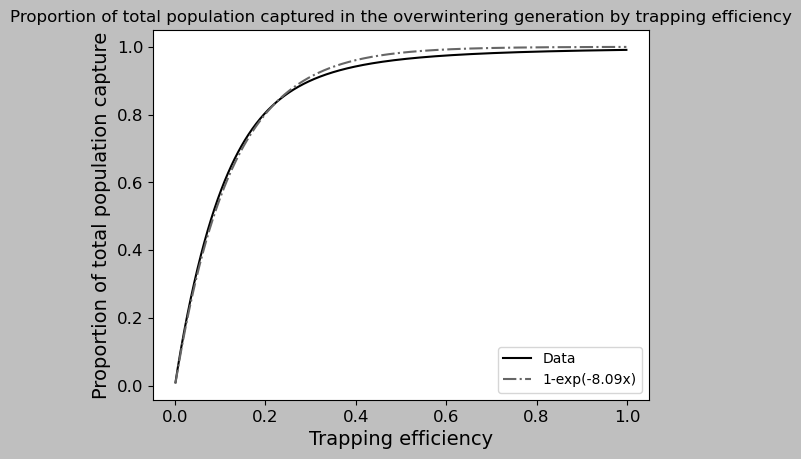

In [66]:
f_f = lambda x, a: (1 - np.exp(a*x))

sns.lineplot(x=max_captures[1], y=max_captures[0], label='Data')

a, b = spop.curve_fit(f_f, max_captures[1], max_captures[0])

sns.lineplot(x=max_captures[1], y=f_f(max_captures[1], a), label='1-exp(-8.09x)', linestyle='-.')
plt.title('Proportion of total population captured in the overwintering generation by trapping efficiency')
plt.ylabel('Proportion of total population capture')
plt.xlabel('Trapping efficiency')
a

In [67]:
max_error = np.max(max_captures[0]-f_f(max_captures[1], a))
bias = np.sum(max_captures[0]-f_f(max_captures[1], a))/len(max_captures[1])
max_error, bias

(np.float64(0.015675041367036235), np.float64(-0.00865323236144411))

In [68]:
field_avg = effort_traps[0].mean()
field_stdev = effort_traps[0].std()
(field_avg - field_stdev, field_avg + field_stdev)

(np.float64(0.004260440933285668), np.float64(0.0062343941170199275))

In [69]:
f_f(field_avg - field_stdev, a)[0], f_f(field_avg + field_stdev, a)[0]

(np.float64(0.0338788449972125), np.float64(0.049184158113225296))

These are absolutely incredible results!!! The two numbers above are the total generational capture proportion predicted by my model for the efficiency values within $\pm$1 standard deviation of the mean for the OKSIR field data, and they are almost perfectly in line with the results from a paper by J.R. Miller et. al. called "Maximizing Information Yield From Pheromone-Baited Monitoring Traps...", which reported usual moth recapture rates for fields with 50-100m releases at ~0.03-0.06. This provides an extremely strong verification of _both_ of the models! The odds are very unlikely that both of these models could work together on real field data to preduce predictions that accurately line up with measurements in field studies on moth recapture rates if either of them lacked true predictive power, or at the very least if they lacked predictive power in the data ranges found in actual fields.

## Evaluate the fit of the models

### adjust phenology to obtain better modeling

In [70]:
def capture_prediction_sb_biofix(dd, effort, max=1, print_coef=False, biofix=69):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    xi = 69
    dd = dd  - (biofix-69)
    if print_coef:
        print(f'{gamma}, {delta}, {llambda}')
    return max * johnsonsb.cdf(dd, gamma, delta, loc=xi, scale=llambda)
def predict_from_full_biofix(dds, captures, CI=False, biofix=69):
    dds = dds - (biofix-69)
    f = lambda dd, effort: capture_prediction_sb(dd, effort, np.max(captures))
    params, pcov = spop.curve_fit(f,dds,captures,p0=[0.005])
    effort = params[0]
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        effort_CI = (effort - S[0]*tval, effort + S[0]*tval)
        return (effort, effort_CI)
    return effort

### test functions

In [71]:
import pprint
fieldnames = ['AllrCoug','CRO','fiveEa','Hansen','HoskGibOth','Royal','ValKoe']
filenames = [field+year for year in ['2018A','2019A','2020A','2021A'] for field in fieldnames]
def mae(filename, plot=False, ddlim=685, biofix=69, residuals=False, errorlim=685):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full_biofix(dds, prop, biofix=biofix)
    y_hat = capture_prediction_sb_biofix(dds, efficacy, biofix=biofix)
    limidx = np.argmax(dds>errorlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(biofix-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanae.round(5), efficacy.round(5), y_hat - prop)
    return (meanae.round(5), efficacy.round(5))
def mae_noadj(filename, ddlim=685, errorlim=685):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full_biofix(dds, prop, biofix=69)
    y_hat = capture_prediction_sb_biofix(dds, 1, biofix=69)
    limidx = np.argmax(dds>errorlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))  
    return meanae.round(5)
def mae_oksir(n, plot=False, ddlim=685, biofix=69, residuals=False, errorlim=685):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    efficacy = predict_from_full_biofix(dds, prop, biofix=biofix)
    y_hat = capture_prediction_sb_biofix(dds, efficacy, biofix=biofix)
    limidx = np.argmax(dds>errorlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(biofix-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanae.round(5), efficacy.round(5), y_hat - prop)
    return (meanae.round(5), efficacy.round(5))
def mae_oksir_noadj(n, ddlim=685, errorlim=685):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    efficacy = predict_from_full_biofix(dds, prop, biofix=69)
    y_hat = capture_prediction_sb_biofix(dds, 1, biofix=69)
    limidx = np.argmax(dds>errorlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))  
    return meanae.round(5)
def mse(filename, plot=False, ddlim=685, biofix=69, residuals=False):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full_biofix(dds, prop, biofix=biofix)
    y_hat = capture_prediction_sb_biofix(dds, efficacy, biofix=biofix)
    meanse = np.mean((y_hat - prop)**2)
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(biofix-69), \
                     y=[jw_emergence(x, 1) for x in np.linspace(0,685, 100)], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanse.round(5), efficacy.round(5), y_hat - prop)
    return (meanse.round(5), efficacy.round(5))
def mse_oksir(n, plot=False, ddlim=685, biofix=69, residuals=False):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    efficacy = predict_from_full_biofix(dds, prop, biofix=biofix)
    y_hat = capture_prediction_sb_biofix(dds, efficacy, biofix=biofix)
    meanse = np.mean((y_hat - prop)**2)
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(biofix-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanse.round(5), efficacy.round(5), y_hat - prop)
    return (meanse.round(5), efficacy.round(5))

### OKSIR data with JW 2012 biofix (xi = 69), and optimize to find likely 'true' biofix 

In [72]:
#oksir no adj no locopt
noadj_oksir = [mae_oksir_noadj(n) for n in range(len(aggs))]
noadj_oksir_mean = np.mean(np.array(noadj_oksir))
pprint.pprint(noadj_oksir)
print(noadj_oksir_mean)

[np.float64(0.32221),
 np.float64(0.20925),
 np.float64(0.32813),
 np.float64(0.21157),
 np.float64(0.28971),
 np.float64(0.3243),
 np.float64(0.38903),
 np.float64(0.33652),
 np.float64(0.25825),
 np.float64(0.30883),
 np.float64(0.24382),
 np.float64(0.28926),
 np.float64(0.42614),
 np.float64(0.40081),
 np.float64(0.23336)]
0.30474599999999996


In [73]:
#oksir with adj no locopt
results_oksir = [mae_oksir(n) for n in range(len(aggs))]
results_oksir_mean = np.mean(np.array(results_oksir).T[0])
pprint.pprint(results_oksir)
print(results_oksir_mean)

[(np.float64(0.05086), np.float64(0.00588)),
 (np.float64(0.0377), np.float64(0.00689)),
 (np.float64(0.01895), np.float64(0.00583)),
 (np.float64(0.02626), np.float64(0.00671)),
 (np.float64(0.06403), np.float64(0.00689)),
 (np.float64(0.10268), np.float64(0.00613)),
 (np.float64(0.08502), np.float64(0.00474)),
 (np.float64(0.0638), np.float64(0.00536)),
 (np.float64(0.05134), np.float64(0.00587)),
 (np.float64(0.06376), np.float64(0.00426)),
 (np.float64(0.0469), np.float64(0.00685)),
 (np.float64(0.03576), np.float64(0.00592)),
 (np.float64(0.11417), np.float64(0.00441)),
 (np.float64(0.08382), np.float64(0.00428)),
 (np.float64(0.08757), np.float64(0.00707))]
0.06217466666666667


In [74]:
smse = [np.sum(np.array([mse_oksir(i, biofix=biofix) for i in range(len(aggs))]).T[0]) for biofix in range(50,170)]
np.min(smse), np.argmin(smse)+50

/tmp/ipykernel_7406/907096657.py:3: RuntimeWarning: invalid value encountered in scalar power
  f_lambda = lambda x, b_0, b_1, b_2, b_3, b_4: np.reciprocal(b_0 * (x ** b_1)) + 577 + (b_2 * logistic.pdf(x, loc=b_3, scale=b_4))


(np.float64(0.04645), np.int64(143))

In [75]:
#oksir with adj with locopt
results_oksir_opt = [mae_oksir(n, biofix=143) for n in range(len(aggs))]
results_oksir_opt_mean = np.mean(np.array(results_oksir_opt).T[0])
pprint.pprint(results_oksir_opt)
print(results_oksir_opt_mean)

[(np.float64(0.01952), np.float64(0.01467)),
 (np.float64(0.01832), np.float64(0.02724)),
 (np.float64(0.04976), np.float64(0.00935)),
 (np.float64(0.02964), np.float64(0.03022)),
 (np.float64(0.02145), np.float64(0.03515)),
 (np.float64(0.04197), np.float64(0.01724)),
 (np.float64(0.04408), np.float64(0.00641)),
 (np.float64(0.02405), np.float64(0.00776)),
 (np.float64(0.02483), np.float64(0.01503)),
 (np.float64(0.03185), np.float64(0.00599)),
 (np.float64(0.05408), np.float64(0.03139)),
 (np.float64(0.06076), np.float64(0.00924)),
 (np.float64(0.0642), np.float64(0.00611)),
 (np.float64(0.05034), np.float64(0.00598)),
 (np.float64(0.04573), np.float64(0.03731))]
0.03870533333333334


In [76]:
np.mean([mae_oksir(i,biofix=143,errorlim=300) for i in range(len(aggs))]).round(5)

np.float64(0.02261)

143 is the optimal integer biofix (location/xi parameter of the Johnson-SB phenology model) between 50 and 170 under the maximum likelihood estimator for normally distributed residuals. The average error was 3.8%, with the early season (before 300 degree days, the prime period for prediction and effective decision making) error being only 2.2%.

(np.float64(0.02483), np.float64(0.01503))

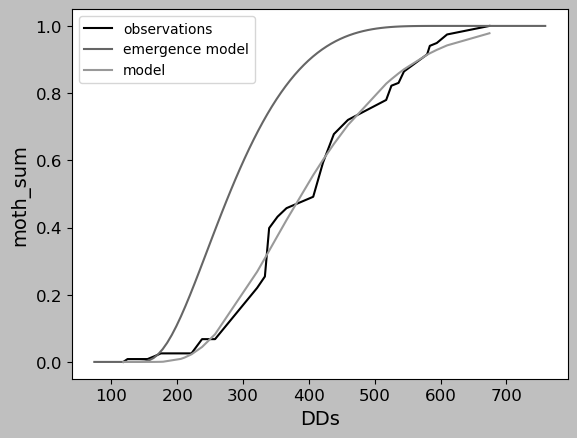

In [126]:
mae_oksir(8, biofix=143, plot=True)

### Four-year field data

In [78]:
#4yrs no adj no locopt
noadj = {filename:mae_noadj(filename) for filename in filenames}
noadj_mean = np.mean(list(noadj.values()))
print('DATA NAME: (MEAN ABSOLUTE ERROR)')
print('----------------------------------------------')
pprint.pprint(noadj)
print(noadj_mean)

DATA NAME: (MEAN ABSOLUTE ERROR)
----------------------------------------------
{'AllrCoug2018A': np.float64(0.03496),
 'AllrCoug2019A': np.float64(0.08885),
 'AllrCoug2020A': np.float64(0.13185),
 'AllrCoug2021A': np.float64(0.15346),
 'CRO2018A': np.float64(0.15442),
 'CRO2019A': np.float64(0.07772),
 'CRO2020A': np.float64(0.07929),
 'CRO2021A': np.float64(0.14795),
 'Hansen2018A': np.float64(0.27728),
 'Hansen2019A': np.float64(0.17852),
 'Hansen2020A': np.float64(0.28421),
 'Hansen2021A': np.float64(0.14714),
 'HoskGibOth2018A': np.float64(0.25395),
 'HoskGibOth2019A': np.float64(0.20119),
 'HoskGibOth2020A': np.float64(0.10936),
 'HoskGibOth2021A': np.float64(0.15838),
 'Royal2018A': np.float64(0.25645),
 'Royal2019A': np.float64(0.21382),
 'Royal2020A': np.float64(0.24108),
 'Royal2021A': np.float64(0.30936),
 'ValKoe2018A': np.float64(0.22896),
 'ValKoe2019A': np.float64(0.08686),
 'ValKoe2020A': np.float64(0.20025),
 'ValKoe2021A': np.float64(0.08981),
 'fiveEa2018A': np.float

In [79]:
#4yrs with adj no locopt
results = {filename:mae(filename) for filename in filenames}
results_mean = np.mean(np.array(list(results.values())).T[0])
print('DATA NAME: (MEAN ABSOLUTE ERROR, NET EFFICACY)')
print('----------------------------------------------')
pprint.pprint(results)
print(results_mean)

DATA NAME: (MEAN ABSOLUTE ERROR, NET EFFICACY)
----------------------------------------------
{'AllrCoug2018A': (np.float64(0.03079), np.float64(0.09988)),
 'AllrCoug2019A': (np.float64(0.08886), np.float64(54835.76196)),
 'AllrCoug2020A': (np.float64(0.01823), np.float64(0.01761)),
 'AllrCoug2021A': (np.float64(0.06363), np.float64(0.00919)),
 'CRO2018A': (np.float64(0.03987), np.float64(0.00791)),
 'CRO2019A': (np.float64(0.07242), np.float64(0.06382)),
 'CRO2020A': (np.float64(0.07854), np.float64(118337.87592)),
 'CRO2021A': (np.float64(0.04172), np.float64(0.0094)),
 'Hansen2018A': (np.float64(0.10712), np.float64(0.00539)),
 'Hansen2019A': (np.float64(0.05503), np.float64(0.00601)),
 'Hansen2020A': (np.float64(0.03642), np.float64(0.00508)),
 'Hansen2021A': (np.float64(0.05452), np.float64(0.00969)),
 'HoskGibOth2018A': (np.float64(0.06163), np.float64(0.00551)),
 'HoskGibOth2019A': (np.float64(0.03879), np.float64(0.00563)),
 'HoskGibOth2020A': (np.float64(0.03311), np.float64(0

In [80]:
filenames = np.sort(filenames)
allr = filenames[0:4]
cro = filenames[4:8]
hansen = filenames[8:12]
hosk = filenames[12:16]
royal = filenames[16:20]
val = filenames[20:24]
five = filenames[24:28]

In [81]:
#AllrCoug
import warnings
warnings.filterwarnings('ignore')
allr = np.delete(allr,1)
smse_allr = [np.sum(np.array([mse(file, biofix=biofix) for file in allr]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
allr_loc = np.argmin(smse_allr)+10
np.min(smse_allr), allr_loc, \
np.mean([mae(file,biofix=allr_loc) for file in allr]).round(5), \
np.mean([mae(file,biofix=allr_loc,errorlim=300) for file in allr]).round(5)

(np.float64(0.00706), np.int64(54), np.float64(0.03058), np.float64(0.0288))

Warning, 2019 data set excluded for extremely non-JSB distributed data, which appears to be due to poor sampling and very low samples overall

In [82]:
#CRO
import warnings
warnings.filterwarnings('ignore')
cro = np.delete(cro,2)
smse_cro = [np.sum(np.array([mse(file, biofix=biofix) for file in cro]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
cro_loc = np.argmin(smse_cro)+10
np.min(smse_cro), cro_loc, \
np.mean([mae(file,biofix=cro_loc) for file in cro]).round(5), \
np.mean([mae(file,biofix=cro_loc,errorlim=300) for file in cro]).round(5)

(np.float64(0.010159999999999999),
 np.int64(37),
 np.float64(0.02944),
 np.float64(0.0287))

In [83]:
#Hansen
import warnings
warnings.filterwarnings('ignore')
hansen = np.delete(hansen,3)
smse_hansen = [np.sum(np.array([mse(file, biofix=biofix) for file in hansen]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
hansen_loc = np.argmin(smse_hansen)+10
np.min(smse_hansen), hansen_loc, \
np.mean([mae(file,biofix=hansen_loc) for file in hansen]).round(5), \
np.mean([mae(file,biofix=hansen_loc,errorlim=300) for file in hansen]).round(5)

(np.float64(0.01163), np.int64(149), np.float64(0.02698), np.float64(0.01168))

Warning on Hansen field, the general trend seems to be for optimal biofix in the 150s, but the last point of data is extremely anamolous, with best fit in the 10s/20s scale.

In [84]:
#Hosk
import warnings
warnings.filterwarnings('ignore')
hosk = np.delete(hosk,3)
smse_hosk = [np.sum(np.array([mse(file, biofix=biofix) for file in hosk]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
hosk_loc = np.argmin(smse_hosk)+10
np.min(smse_hosk), hosk_loc, \
np.mean([mae(file,biofix=hosk_loc) for file in hosk]).round(5), \
np.mean([mae(file,biofix=hosk_loc,errorlim=300) for file in hosk]).round(5)

(np.float64(0.01259), np.int64(110), np.float64(0.03487), np.float64(0.02264))

Warning on Hosk field, 2021 data set excluded for extremely non-JSB distributed data, which appears to be due to poor and low sampling.

In [85]:
#Royal
import warnings
warnings.filterwarnings('ignore')
smse_royal = [np.sum(np.array([mse(file, biofix=biofix) for file in royal]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
royal_loc = np.argmin(smse_royal)+10
np.min(smse_royal), royal_loc, \
np.mean([mae(file,biofix=royal_loc) for file in royal]).round(5), \
np.mean([mae(file,biofix=royal_loc,errorlim=300) for file in royal]).round(5)

(np.float64(0.01339), np.int64(138), np.float64(0.02881), np.float64(0.0265))

In [86]:
#Val
import warnings
warnings.filterwarnings('ignore')
smse_val = [np.sum(np.array([mse(file, biofix=biofix) for file in val]).T[0]) for biofix in range(10,150)]
warnings.filterwarnings('default')
val_loc = np.argmin(smse_val)+10
np.min(smse_val), val_loc, \
np.mean([mae(file,biofix=val_loc) for file in val]).round(5), \
np.mean([mae(file,biofix=val_loc,errorlim=300) for file in val]).round(5)

(np.float64(0.015260000000000001),
 np.int64(82),
 np.float64(0.03665),
 np.float64(0.03072))

In [87]:
#Five
import warnings
warnings.filterwarnings('ignore')
five = np.delete(five,2)
smse_five = [np.sum(np.array([mse(file, biofix=biofix) for file in five]).T[0]) for biofix in range(10,120)]
warnings.filterwarnings('default')
five_loc = np.argmin(smse_five)+10
np.min(smse_five), five_loc, \
np.mean([mae(file,biofix=five_loc) for file in five]).round(5), \
np.mean([mae(file,biofix=five_loc,errorlim=300) for file in five]).round(5)

(np.float64(0.00928), np.int64(57), np.float64(0.02182), np.float64(0.01828))

Warning on five field, 2020 data set excluded due to extremely non-JSB distributed data seemingly due to poor sampling and low sample size.

One interesting observation I have noticed while going through the shapes of all these datasets is that some of them have minor deviations from Johnson-SB shapes in a similar way, a where the start and end of the generation are about as expected, but there is a strange plataeu in the middle section of the data. Worth looking into in the future. Possibly due to disruptions in mobility like more extreme weather? It also seems as though there is a more common biofix for regions that can be perturbed by some external process. Future research should focus on figuring out the processes that perturb the biofix and the degree of fit to the JSB distribution. It could be the apparent perturbation of optimal biofix is a actually just a perturbation of the capture data like that I observed in the middle of the generations except consistently applied to the whole visible generation, causing a somewhat uniform translation that looks like a change in biofix. These things should all be considered when looking capture data, which is subject to an unenumerable amount of confounding factors.

In [88]:
def biofix_plot_file(filename, ax, ddlim=685, biofix=69):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full_biofix(dds, prop, biofix=biofix)
    y_hat = capture_prediction_sb_biofix(dds, efficacy, biofix=biofix)
    #meanae = np.mean(np.abs(y_hat - prop))
    limidx = np.argmax(dds>ddlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))
    sns.lineplot(x=dds, y=prop, label='observations', ax=ax, linestyle='-.')
    sns.lineplot(x=np.linspace(0,685, 100)+(biofix-69), \
                      y=[jw_emergence(x, 1) for x in np.linspace(0,685, 100)], \
                      label=f'phenology \n(location = {biofix})', ax=ax)
    sns.lineplot(x=dds, y=y_hat, label=f'model \n(efficacy = \n {efficacy.round(5)}\nMAE=\n{meanae.round(5)})', ax=ax, linestyle=':')
    ax.set_title(f'{filename}')
    ax.set_xlabel('CDD')
    ax.set_ylabel('moths')
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[2:3], labels[2:3])

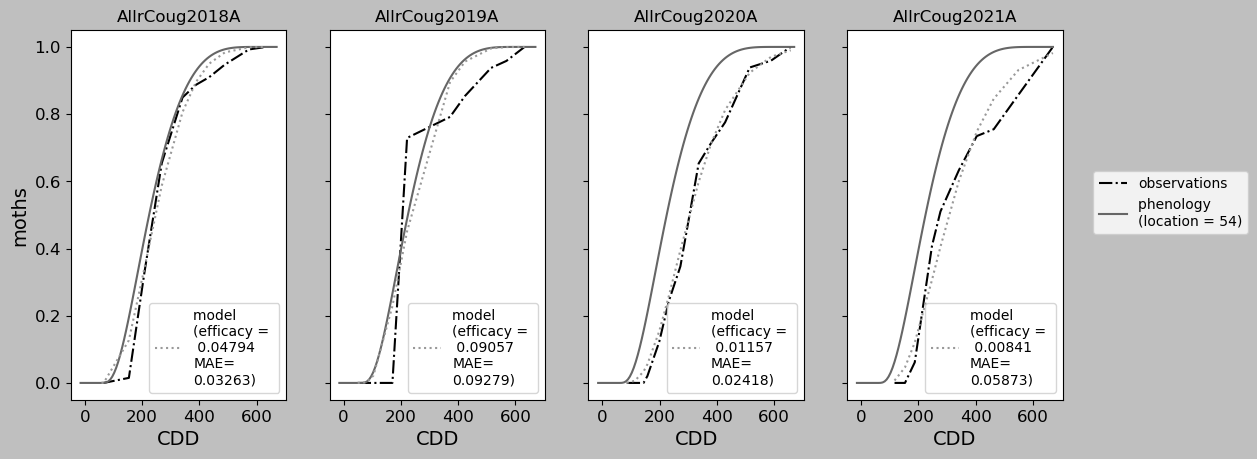

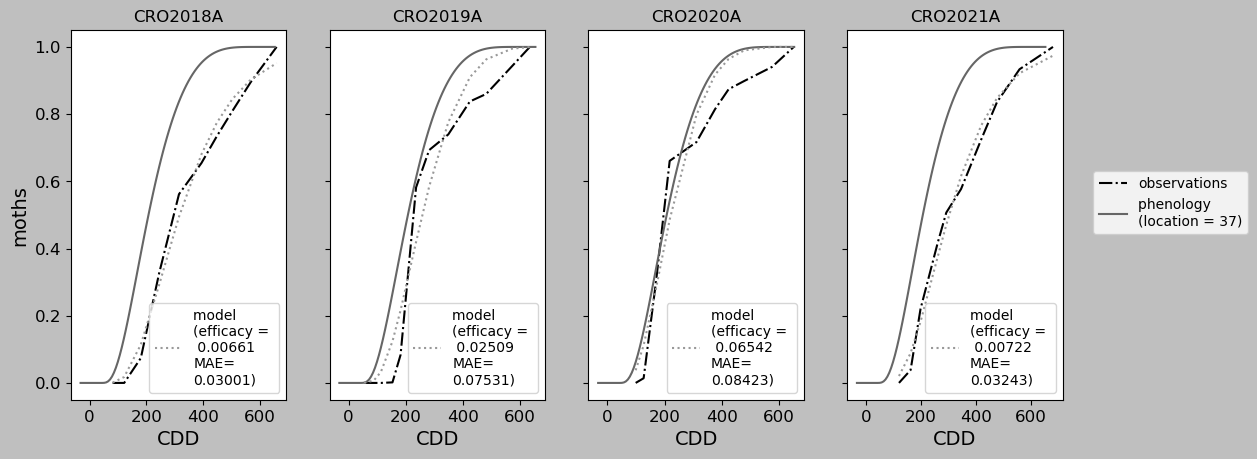

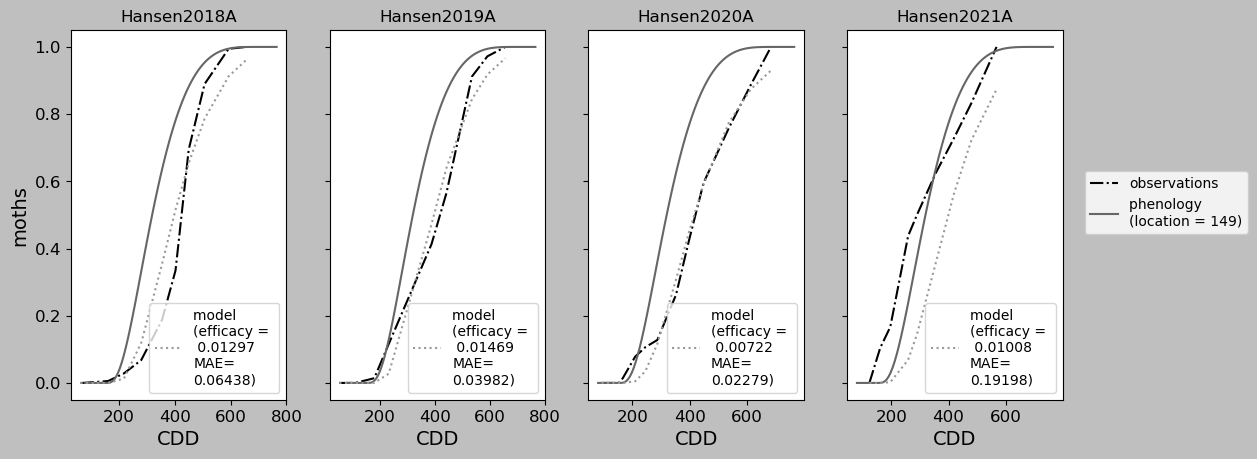

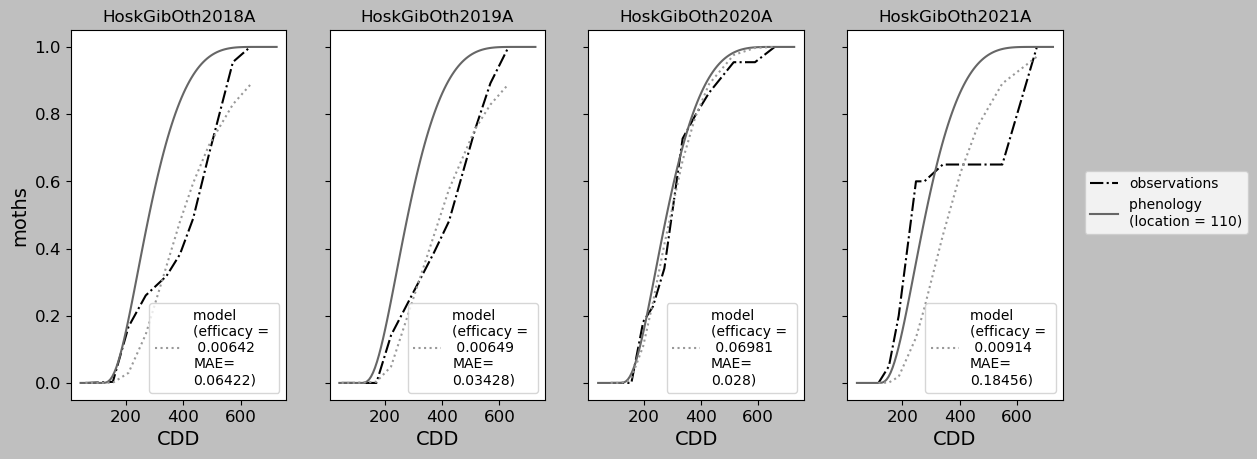

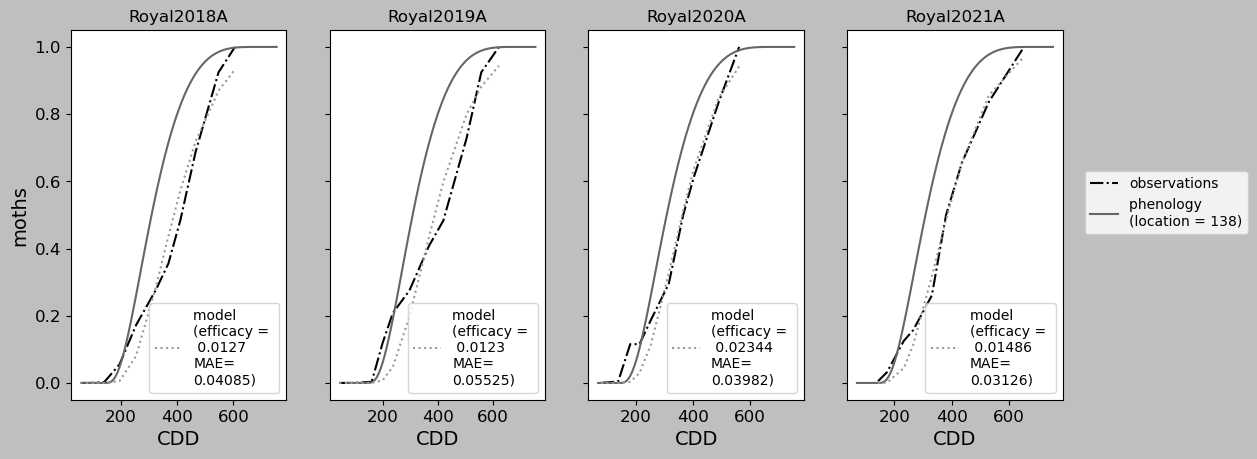

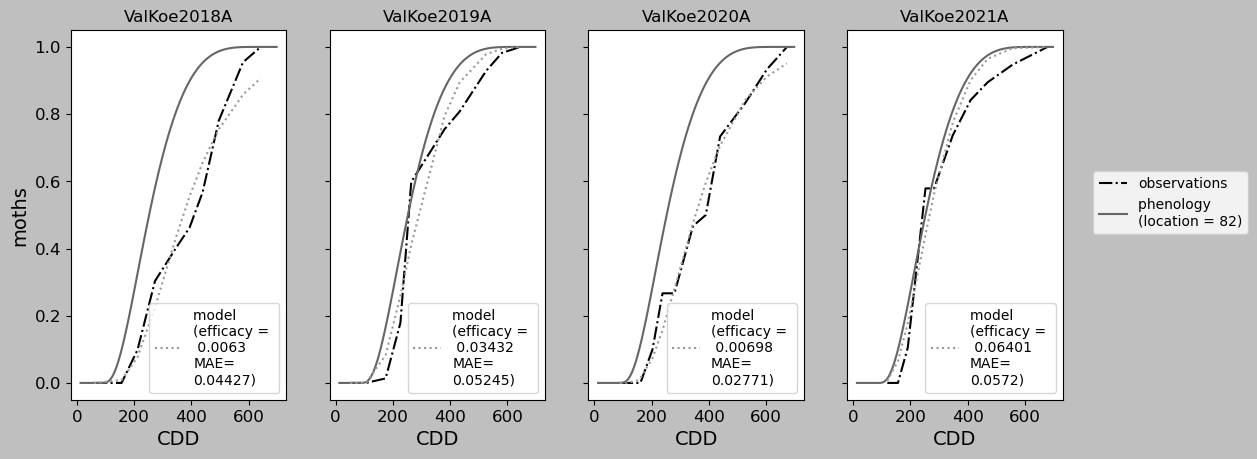

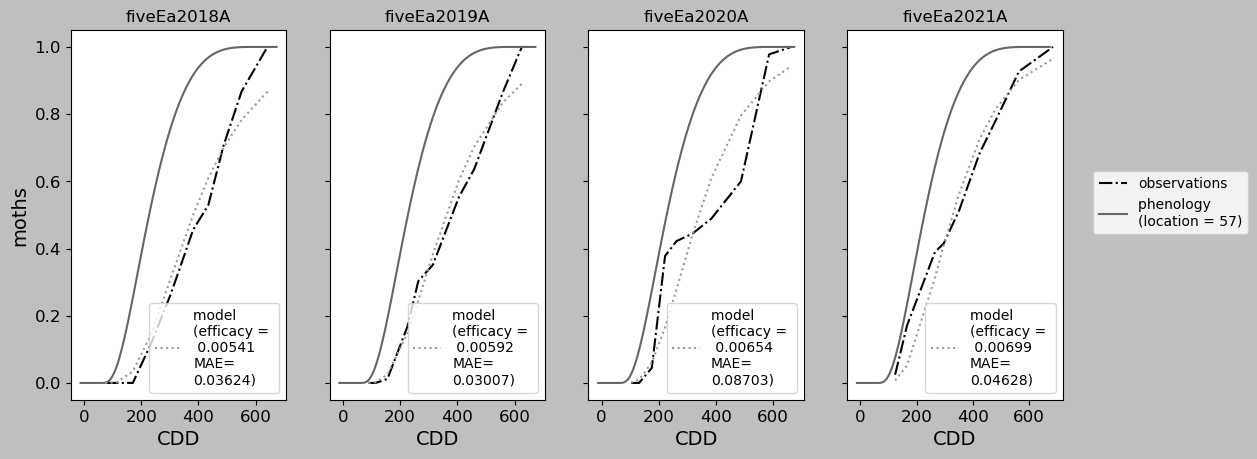

In [89]:
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec
def facet_results_files(dset,loc):
    fig = plt.figure()
    axes = fig.subplots(1, len(dset), sharey=True)
    for i, file in enumerate(dset):
        biofix_plot_file(file, axes[i], ddlim=685, biofix=loc)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels[0:2], bbox_to_anchor=(1.05, 0.6))
    fig_width, fig_height = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(fig_width*2, fig_height)

allr = filenames[0:4]
cro = filenames[4:8]
hansen = filenames[8:12]
hosk = filenames[12:16]
royal = filenames[16:20]
val = filenames[20:24]
five = filenames[24:28]
facet_results_files(allr,54)
facet_results_files(cro,37)
facet_results_files(hansen,149)
facet_results_files(hosk,110)
facet_results_files(royal,138)
facet_results_files(val, 82)
facet_results_files(five,57)

In [90]:
#4yrs with adj with locopt
locs = [54,37,149,110,138,82,57]
results_loc = {filename:mae(filename,biofix=locs[math.floor(i/4)]) for i,filename in enumerate(filenames)}
results_loc_mean = np.mean(np.array(list(results_loc.values())).T[0])
print('DATA NAME: (MEAN ABSOLUTE ERROR, NET EFFICACY)')
print('----------------------------------------------')
pprint.pprint(results_loc)
print(results_loc_mean)

DATA NAME: (MEAN ABSOLUTE ERROR, NET EFFICACY)
----------------------------------------------
{np.str_('AllrCoug2018A'): (np.float64(0.03263), np.float64(0.04794)),
 np.str_('AllrCoug2019A'): (np.float64(0.09279), np.float64(0.09057)),
 np.str_('AllrCoug2020A'): (np.float64(0.02418), np.float64(0.01157)),
 np.str_('AllrCoug2021A'): (np.float64(0.05873), np.float64(0.00841)),
 np.str_('CRO2018A'): (np.float64(0.03001), np.float64(0.00661)),
 np.str_('CRO2019A'): (np.float64(0.07531), np.float64(0.02509)),
 np.str_('CRO2020A'): (np.float64(0.08423), np.float64(0.06542)),
 np.str_('CRO2021A'): (np.float64(0.03243), np.float64(0.00722)),
 np.str_('Hansen2018A'): (np.float64(0.06438), np.float64(0.01297)),
 np.str_('Hansen2019A'): (np.float64(0.03982), np.float64(0.01469)),
 np.str_('Hansen2020A'): (np.float64(0.02279), np.float64(0.00722)),
 np.str_('Hansen2021A'): (np.float64(0.19198), np.float64(0.01008)),
 np.str_('HoskGibOth2018A'): (np.float64(0.06422), np.float64(0.00642)),
 np.str_(

In [91]:
# mean no adj no locopt
noadj_noloc = np.append(np.array(noadj_oksir),list(noadj.values()))
(np.min(noadj_noloc),\
np.mean(noadj_noloc),\
np.max(noadj_noloc))

(np.float64(0.03496), np.float64(0.22120767441860464), np.float64(0.42614))

In [92]:
# mean with adj no locopt
adj_noloc = np.append(np.array(results_oksir).T[0],np.array(list(results.values())).T[0])
(np.min(adj_noloc),\
np.mean(adj_noloc),\
np.max(adj_noloc))

(np.float64(0.01823), np.float64(0.056782790697674425), np.float64(0.14832))

In [93]:
effs_adj = np.append(np.array(results_oksir).T[1],np.array(list(results.values())).T[1])
(np.min(effs_adj),\
np.mean(effs_adj),\
np.max(effs_adj))

(np.float64(0.00426), np.float64(4027.3053423255815), np.float64(118337.87592))

In [94]:
# mean with adj with locopt
np.mean(np.append(np.array(results_oksir_opt).T[0],np.array(list(results_loc.values())).T[0]))

np.float64(0.05091511627906976)

Text(0.5, 0, 'MAE')

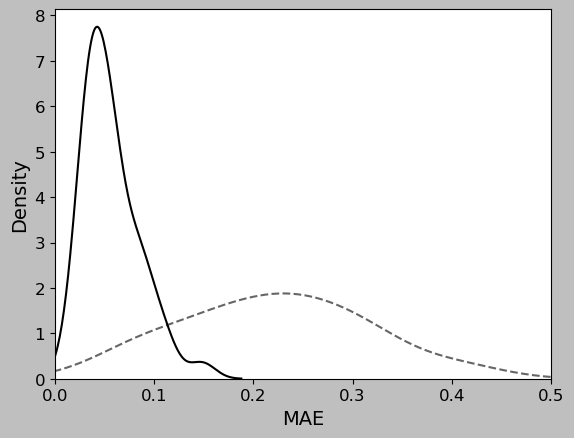

In [95]:
adjres = np.array(list(results.values())).T[0]
adjres = np.concatenate((adjres, np.array(results_oksir).T[0]))
noadjres = np.array(list(noadj.values()))
noadjres = np.concatenate((noadjres, np.array(noadj_oksir)))

ax = sns.kdeplot([adjres, noadjres], legend=False)
ax.lines[0].set_linestyle("--")
plt.xlim(0,0.5)
plt.xlabel('MAE')

### Steepness of observation data and phenology

In [96]:
from scipy.optimize import minimize
gamma = rationaln_n(effort, *popt_gammas)
delta = rationaln_n(effort, *popt_deltas)
llambda = f_lambda(effort, *popt_lambdas)
xi = 69
def neg_jsb_pdf(x):
    return -johnsonsb.pdf(x, gamma, delta, loc=xi, scale=llambda)
-minimize(neg_jsb_pdf,350).fun

0.0015498910996997273

The greatest density of the phenology function at any given time is 0.00155. Let's compare this to the field data. The slopes are average rates of change (average derivatives) along the data intervals. Since an average is always less than or equal to the maximum along the set it was determined from, the maximum slope from a set of capture data is a lower bound on its true maximum density. We should expect that the traps won't capture bugs faster than their maximum rate of emergence, although I doubt that is the case.

In [97]:
def max_slope(i):
    dds = aggs[i].DDs
    captures = aggs[i].moth_sum
    dds = dds[dds < 685]
    captures = captures[:len(dds)]
    captures = captures / np.max(captures)
    d_dd = np.diff(dds)
    d_captures = np.diff(captures)
    return np.max(d_captures / d_dd)
slopes = np.array([max_slope(i) for i in range(len(aggs))])
print(slopes[slopes>0.00155])

[0.0032083  0.00395395 0.00294652 0.00328822 0.00512893 0.00420038
 0.01300502 0.01253563 0.02234622 0.00657199 0.01880229 0.0120088
 0.01389052 0.02443569 0.03970296]


As expected, there are many slopes greater than the maximum density of the phenology curve. If we assume the shape of the phenology curve is true, than the true proportional capture density functions have regions where the proportional rate of capture is greater than the greatest proportional rate of emergence. This violates an assumption made by the accumulating binomial delay model we used to construct the parameter relationship between the phenology and capture data, although as evidenced by the low MAE scores obtained above, the model is respectably robust against the degree of violation displayed in most of the data. The fact that the violation is to a low enough degree that our model maintains reasonably low errors reinforces the idea that the primary mechanism differentiating capture data from phenology curves is an accumulating binomial delay, but the existence of the violation provides yet more evidence that there are other confounding factors at play.

## check relationship between average cumulative captures and error

In [98]:
def cumavg_captures(file):
    data = pd.read_csv('verification_data/'+file+'.csv').dropna()
    total = data.iloc[:,3].cumsum().tail(1).item()
    traps = data.iloc[:,2].max()
    return total / traps
def cumavg_captures_oksir(n):
    data = aggs[n]
    total = data.iloc[:,3].cumsum().tail(1).item()
    traps = data.iloc[:,2].max()
    return total / traps
biofixes = {'AllrCoug':54,
            'CRO':37,
            'Hansen':149,
            'HoskGibOth':110,
            'Royal':138,
            'ValKoe':82,
            'fiveEa':57}
warnings.filterwarnings('ignore')
avgcaps_mae = np.array([(cumavg_captures(file[:-1]),mae(file, biofix=biofixes[file[:-5]])[0]) for file in filenames]).T
maecaps = pd.DataFrame({'average_captures':avgcaps_mae[0],'MAE':avgcaps_mae[1]})
model_maecaps = smf.ols('np.log(MAE) ~ np.log(average_captures)', data=maecaps).fit()
model_maecaps_lin = smf.ols('MAE ~ average_captures', data=maecaps).fit()
#sns.lineplot(x=maecaps.average_captures, y=maecaps.MAE.rolling(2).agg('mean'), label='cumulative mean')
#sns.lineplot(x=maecaps.average_captures, y=maecaps.MAE.rolling(2).agg('var'), label='cumulative variance')
warnings.filterwarnings('default')
print(model_maecaps.summary())
print(model_maecaps_lin.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(MAE)   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.711
Date:                Wed, 09 Oct 2024   Prob (F-statistic):             0.0393
Time:                        19:53:42   Log-Likelihood:                -20.120
No. Observations:                  28   AIC:                             44.24
Df Residuals:                      26   BIC:                             46.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

                            OLS Regression Results                            
Dep. Variable:            np.log(MAE)   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     7.296
Date:                Wed, 09 Oct 2024   Prob (F-statistic):             0.0120
Time:                        19:53:42   Log-Likelihood:                -16.729
No. Observations:                  28   AIC:                             37.46
Df Residuals:                      26   BIC:                             40.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

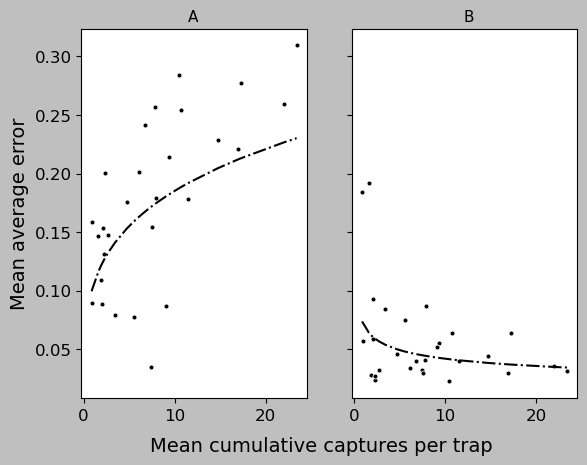

In [99]:
warnings.filterwarnings('ignore')
avgcaps_mae_noadj = np.array([(cumavg_captures(file[:-1]),mae_noadj(file)) for file in filenames]).T
maecaps_noadj = pd.DataFrame({'average_captures':avgcaps_mae_noadj[0],'MAE':avgcaps_mae_noadj[1]})
model_maecaps_noadj = smf.ols('np.log(MAE) ~ np.log(average_captures)', data=maecaps_noadj).fit()
model_maecaps_noadj_lin = smf.ols('MAE ~ average_captures', data=maecaps_noadj).fit()

fig_maecaps = plt.figure()
axes_maecaps = fig_maecaps.subplots(1, 2, sharey=True)
sns.scatterplot(x=maecaps_noadj.average_captures, y=maecaps_noadj.MAE,s=50,marker=".", ax=axes_maecaps[0])
sns.lineplot(x=maecaps_noadj.average_captures, y=np.exp(model_maecaps_noadj.predict(maecaps_noadj.average_captures)),linestyle='-.', ax=axes_maecaps[0])
#sns.lineplot(x=maecaps_noadj.average_captures, y=model_maecaps_noadj_lin.predict(maecaps_noadj.average_captures),linestyle=':', ax=axes_maecaps[0])
axes_maecaps[0].set_xlabel('')
axes_maecaps[0].set_ylabel('Mean average error')
sns.scatterplot(x=maecaps.average_captures, y=maecaps.MAE,s=50,marker=".", ax=axes_maecaps[1])
sns.lineplot(x=maecaps.average_captures, y=np.exp(model_maecaps.predict(maecaps.average_captures)),linestyle='-.', ax=axes_maecaps[1])
#sns.lineplot(x=maecaps.average_captures, y=model_maecaps_lin.predict(maecaps.average_captures),linestyle=':', ax=axes_maecaps[1])
axes_maecaps[1].set_xlabel('')
fig_maecaps.text(0.5, 0, 'Mean cumulative captures per trap', ha='center',size=14)
fig_maecaps.text(0.3, 0.895, 'A', ha='center',size=11)
fig_maecaps.text(0.73, 0.895, 'B', ha='center',size=11)
#plt.savefig('./figures/finals/avgcumcaps.png',dpi=300,bbox_inches='tight')

warnings.filterwarnings('default')
print(model_maecaps_noadj.summary())
print(model_maecaps_noadj_lin.summary())

In [100]:
np.exp(-2.6329)

np.float64(0.07186973749543275)

Poor model fitting seems to be a symptom of high sampling error. Too little moths for the number of traps, which creates bad data. As number of moths increases error becomes more and more predictably stable, at around 4% MAE.

In [101]:
lowsamples = {filename:(cumavg_captures(filename[:-1])>2.5) for filename in filenames}
lowsamples_oksir = {n:(cumavg_captures_oksir(n)>2.5) for n in range(len(aggs))}
pprint.pprint(lowsamples)
pprint.pprint(lowsamples_oksir)

{np.str_('AllrCoug2018A'): np.True_,
 np.str_('AllrCoug2019A'): np.False_,
 np.str_('AllrCoug2020A'): np.False_,
 np.str_('AllrCoug2021A'): np.False_,
 np.str_('CRO2018A'): np.True_,
 np.str_('CRO2019A'): np.True_,
 np.str_('CRO2020A'): np.True_,
 np.str_('CRO2021A'): np.True_,
 np.str_('Hansen2018A'): np.True_,
 np.str_('Hansen2019A'): np.True_,
 np.str_('Hansen2020A'): np.True_,
 np.str_('Hansen2021A'): np.False_,
 np.str_('HoskGibOth2018A'): np.True_,
 np.str_('HoskGibOth2019A'): np.True_,
 np.str_('HoskGibOth2020A'): np.False_,
 np.str_('HoskGibOth2021A'): np.False_,
 np.str_('Royal2018A'): np.True_,
 np.str_('Royal2019A'): np.True_,
 np.str_('Royal2020A'): np.True_,
 np.str_('Royal2021A'): np.True_,
 np.str_('ValKoe2018A'): np.True_,
 np.str_('ValKoe2019A'): np.True_,
 np.str_('ValKoe2020A'): np.False_,
 np.str_('ValKoe2021A'): np.False_,
 np.str_('fiveEa2018A'): np.True_,
 np.str_('fiveEa2019A'): np.True_,
 np.str_('fiveEa2020A'): np.True_,
 np.str_('fiveEa2021A'): np.True_}
{0: 

In [102]:
filenames_clean = np.delete(filenames[np.array(list(lowsamples.values()))],[0,2,3,18])
#clean out the files with too few moths per trap or those with high error caused by non-Johnson-SB distribution
#also remove AllrCoug, because the other three are so high error that the location parameter estimation isn't reliable for the remaining fieldyear
filenames_clean

array(['CRO2018A', 'CRO2021A', 'Hansen2018A', 'Hansen2019A',
       'Hansen2020A', 'HoskGibOth2018A', 'HoskGibOth2019A', 'Royal2018A',
       'Royal2019A', 'Royal2020A', 'Royal2021A', 'ValKoe2018A',
       'ValKoe2019A', 'fiveEa2018A', 'fiveEa2019A', 'fiveEa2021A'],
      dtype='<U15')

### See if number of traps correlates to efficacy at all

<Axes: xlabel='number of traps', ylabel='fitted efficacy'>

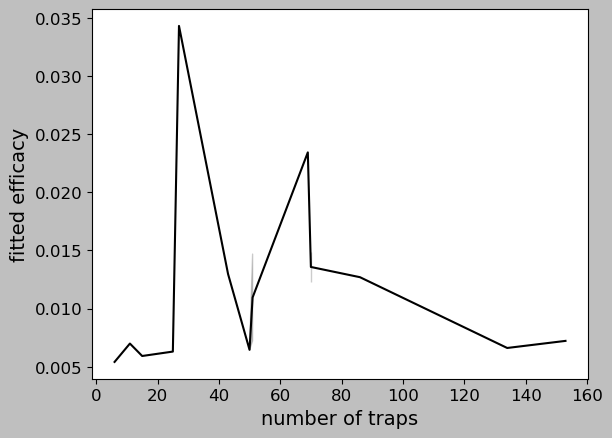

In [103]:
def count_traps(filename) -> int:
    return pd.read_csv('verification_data/'+filename+'.csv').dropna().iloc[:,2].max()
files = [x for xs in [allr, cro, hansen, hosk, royal, val, five] for x in xs]
plt.xlabel('number of traps')
plt.ylabel('fitted efficacy')
traps_eff = np.array([(count_traps(file[:-1]),mse(file, biofix=biofixes[file[:-5]])[1]) for file in filenames_clean]).T
sns.lineplot(x=traps_eff[0], y=traps_eff[1])

Number of traps not a good proxy, need trapping density, then I can rerun this analysis.

(array([ 3.51962938e-01, -1.61109806e-03,  7.55606076e+01, -1.66351694e+01]),
 np.float64(0.12066666666666666))

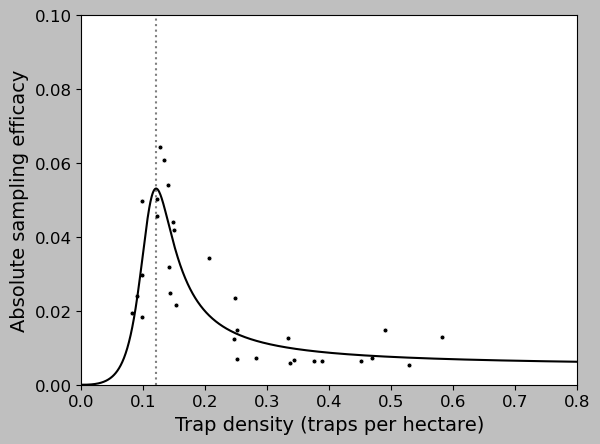

In [104]:
import scipy.stats

warnings.filterwarnings('ignore')
densities = pd.read_csv('trap_densities.csv')
densities_oksir = pd.read_csv('oksir_densities.csv')
plt.xlabel('Trap density (traps per hectare)')
plt.ylabel('Absolute sampling efficacy')
plt.xlim(0,0.6)
traps_eff2_oksir = np.array([(\
                        densities_oksir.iloc[n].density.item(),\
                        mae_oksir(n, biofix=143)[0]) \
                        for n in range(len(aggs))\
                      ])
traps_eff2_4yr = np.array([(\
                        densities[densities.field_name==file].density.item(),\
                        mae(file, biofix=biofixes[file[:-5]])[1]) \
                        for file in filenames_clean\
                      ])
traps_eff2 = np.append(traps_eff2_oksir, traps_eff2_4yr, axis=0).T
#traps_eff2 = np.append([[0,0]],traps_eff2,axis=0).T
dens_eff = pd.DataFrame({'density':traps_eff2[0],'efficacy':traps_eff2[1]})

def f_dens(x, p0, p1, q1, q2):
    return rational(x, [p0, p1, 0], [q1, q2])
popt_dens = spop.curve_fit(f_dens, dens_eff.density, dens_eff.efficacy)[0]

sns.scatterplot(x=dens_eff.density, y=dens_eff.efficacy,s=50,marker=".")
interp = np.linspace(0,1,1500)
sns.lineplot(x=interp, y=f_dens(interp,*popt_dens))
plt.axvline(0.12, linestyle=':', alpha=0.5)
plt.ylim(0,0.1)
plt.xlim(0,0.8)
#plt.savefig('./figures/finals/density_efficacy.png',dpi=300,bbox_inches='tight')
popt_dens, np.argmax(f_dens(interp,*popt_dens))*(1/1500)

In [105]:
(np.min(traps_eff2[1]),\
np.mean(traps_eff2[1]),\
np.max(traps_eff2[1]))

(np.float64(0.00541), np.float64(0.024659354838709683), np.float64(0.0642))

[0.25552294 0.05568023 8.33351695 1.35381935]


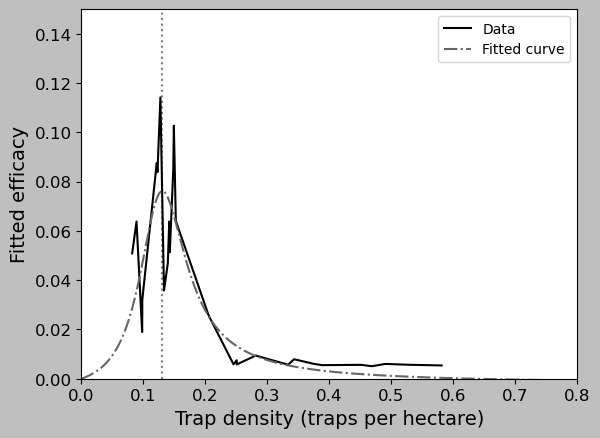

In [106]:
import scipy.stats
warnings.filterwarnings('ignore')
densities = pd.read_csv('trap_densities.csv')
densities_oksir = pd.read_csv('oksir_densities.csv')
plt.xlabel('Trap density (traps per hectare)')
plt.ylabel('Fitted efficacy')
plt.xlim(0,0.6)
traps_eff2_oksir = np.array([(\
                        densities_oksir.iloc[n].density.item(),\
                        mae_oksir(n, biofix=69)[0]) \
                        for n in range(len(aggs))\
                      ])
traps_eff2_4yr = np.array([(\
                        densities[densities.field_name==file].density.item(),\
                        mae(file, biofix=69)[1]) \
                        for file in filenames_clean\
                      ])
traps_eff2 = np.append(traps_eff2_oksir, traps_eff2_4yr, axis=0).T
#traps_eff2 = np.append([[0,0]],traps_eff2,axis=0).T
dens_eff = pd.DataFrame({'density':traps_eff2[0],'efficacy':traps_eff2[1]})

def f_dens(x, p0, p1, q1, q2):
    return rational(x, [p0, p1, 0], [q1, q2])
popt_dens, pcov_dens = spop.curve_fit(f_dens, dens_eff.density, dens_eff.efficacy)
sns.lineplot(x=dens_eff.density, y=dens_eff.efficacy, label="Data")
interp = np.linspace(0,1,1500)
sns.lineplot(x=interp, y=f_dens(interp,*popt_dens), linestyle="-.", label="Fitted curve")
plt.axvline(0.13, linestyle=':', alpha=0.5)
plt.ylim(0,0.15)
plt.xlim(0,0.8)
popt_dens, np.argmax(f_dens(interp,*popt_dens))*(1/1500)
print(np.sqrt(np.diag(pcov_dens)))

### Look at relationship between latitude and location parameter

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               locparam   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     3.363
Date:                Wed, 09 Oct 2024   Prob (F-statistic):              0.126
Time:                        19:53:43   Log-Likelihood:                -34.029
No. Observations:                   7   AIC:                             72.06
Df Residuals:                       5   BIC:                             71.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6874.4449   3699.784      1.858      0.122   -2636.151    1.64e+04
lat         -144.1991     78.631     -1.834      0.126    -346.327      57.928
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.763
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.442
Skew:                          -0.210   Prob(JB):                        0.802
Kurtosis:                       1.843   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

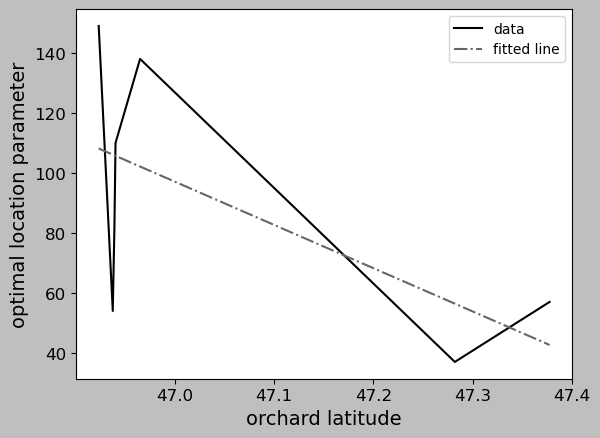

In [107]:
lat = {'AllrCoug':46.9375036,
       'CRO':47.2820226,
       'Hansen':46.9233333,
       'HoskGibOth':46.9402814,
       'Royal':46.9650036,
       'ValKoe':46.9391703,
       'fiveEa':47.3774572}
latloc = pd.DataFrame({'lat':list(lat.values()), 'locparam':list(biofixes.values())})
model = smf.ols('locparam ~ lat', data=latloc).fit()
plt.xlabel('orchard latitude')
plt.ylabel('optimal location parameter')
sns.lineplot(x=latloc.lat, y=latloc.locparam, label='data')
sns.lineplot(x=latloc.lat, y=model.predict(latloc.lat), label=f'fitted line',linestyle='-.')
model.summary()

It appears like there could be a trend here, but there are three problems with coming to conclusions. 1: not enough fields to get statistical significance to a negative relationship. 2: each optimal location parameter is being estimated from only 3 or 4 years of data, which isn't much at all. 3: The difference between the minimum and maxiumum value in latitude is only like half a degree. Take this as a demonstration of a methodology for a future study that takes into account fields with more years of data in each and stretching between BC and SoCal to get something more meaningful. Until then, for orchard profiling, asymptotic estimation for each new year of data is recommended.

## See if population effects shape

In [108]:
big_df = pd.read_csv('test_1.csv')
big_dfs = np.array_split(big_df, len(big_df)/big_df.dd_span.head(1).iloc[0])

In [109]:
big_dfs_424 = [big_dfs[16 + (i*84)] for i in range(20)]

In [110]:
f = lambda dd, gamma, delta, llambda: johnsonsb.cdf(dd, gamma, delta, loc=69, scale=llambda)
params = []
for n in range(20):
    x_opt = np.arange(0,big_dfs_424[n].dd.max()+1,1)
    y_opt = big_dfs_424[n].pop_captured_0 / big_dfs_424[n].head(1).eggs_total_0.item()
    effort = big_dfs_424[n].head(1).prob_capture.item()
    gamma, delta, llambda = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
    params.append((gamma, delta, llambda, effort))

params = np.array(params).T
gammas = params[0]
deltas = params[1]
lambdas = params[2]
efforts = params[3]

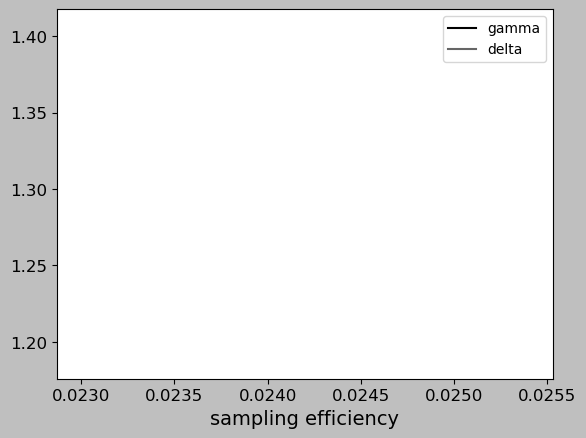

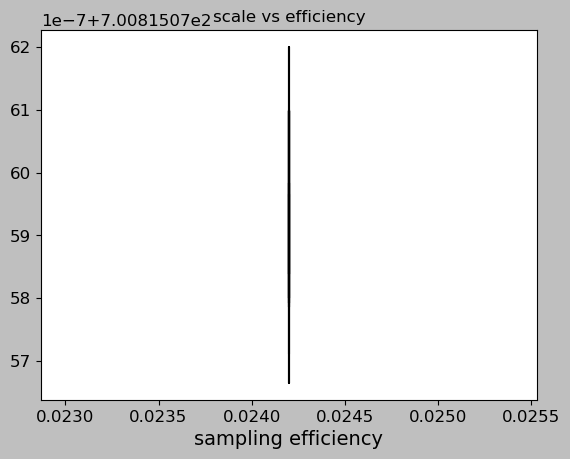

In [111]:
plt.xlabel('sampling efficiency')
sns.lineplot(x=efforts,y=gammas, label='gamma')
sns.lineplot(x=efforts,y=deltas, label='delta')
plt.figure()
plt.title('scale vs efficiency')
plt.xlabel('sampling efficiency')
plt.plot(efforts,lambdas)

In [112]:
gammas, lambdas

(array([1.18689582, 1.18689582, 1.18689582, 1.18689583, 1.18689582,
        1.18689582, 1.18689583, 1.18689583, 1.18689583, 1.18689582,
        1.18689582, 1.18689583, 1.18689582, 1.18689583, 1.18689582,
        1.18689582, 1.18689583, 1.18689582, 1.18689582, 1.18689582]),
 array([700.81507596, 700.81507579, 700.8150758 , 700.8150761 ,
        700.81507579, 700.81507593, 700.815076  , 700.81507604,
        700.8150761 , 700.81507584, 700.81507594, 700.8150762 ,
        700.81507596, 700.8150761 , 700.81507585, 700.8150758 ,
        700.81507598, 700.81507566, 700.81507596, 700.81507571]))

## correct for early generation underestimations and late generation overestimations

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     16.30
Date:                Wed, 09 Oct 2024   Prob (F-statistic):            0.00141
Time:                        19:53:49   Log-Likelihood:                 116.92
No. Observations:                  15   AIC:                            -229.8
Df Residuals:                      13   BIC:                            -228.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.613      0.0

<Axes: >

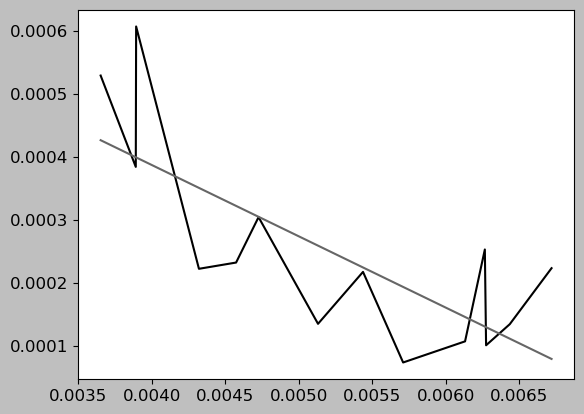

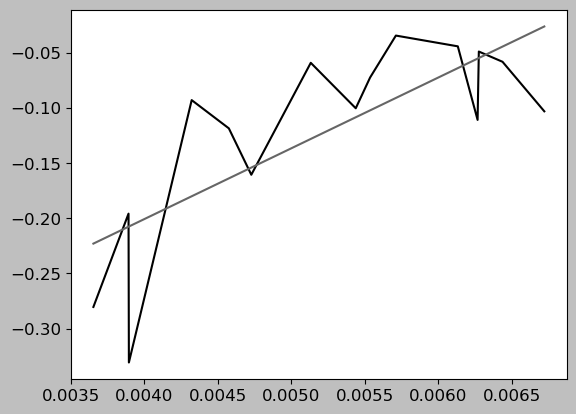

In [113]:
res = []
for i, efficacy in enumerate(effort_traps[0]):
    capture_x = aggs[i].DDs
    capture_y = aggs[i].moth_sum
    capture_x = np.array(capture_x[capture_x < 800])
    capture_y = np.array(capture_y[:len(capture_x)])
    capture_y = capture_y/np.max(capture_y)
    prediction_y = capture_prediction_sb(np.array(capture_x), efficacy, 1)
    res.append(((capture_y-prediction_y), capture_x))

#print(res)

models = []
for r in res:
    x = r[1]
    y = r[0]
    model = sm.OLS(y, sm.add_constant(x)).fit()
    models.append((model.params[0], model.params[1]))
models = np.array(models).T


model_m = sm.OLS(models[1],sm.add_constant(effort_traps[0])).fit()
print(model_m.summary())
sns.lineplot(x=effort_traps[0], y=models[1])
sns.lineplot(x=effort_traps[0], y=(model_m.params[1])* effort_traps[0] + (model_m.params[0]))
plt.figure()
model_b = sm.OLS(models[0],sm.add_constant(effort_traps[0])).fit()
print(model_b.summary())
sns.lineplot(x=effort_traps[0], y=models[0])
sns.lineplot(x=effort_traps[0], y=(model_b.params[1])* effort_traps[0] + (model_b.params[0]))

## better total capture estimation using cumulative value constant proportionality

In [114]:
import scipy.stats as stats

def capture_prediction_sb_cumul(efficacy, dd, test_max=1.0):
    gamma = rationaln_n(efficacy, *popt_gammas)
    delta = rationaln_n(efficacy, *popt_deltas)
    llambda = f_lambda(efficacy, *popt_lambdas)
    xi = 69
    return test_max * johnsonsb.cdf(dd, gamma, delta, loc=xi, scale=llambda)

def capture_prediction_sb_cumul_adj(efficacy, dd, test_max=1.0):
    correction_term = ((model_m.params[1])*efficacy + (model_m.params[0]))*dd \
                        + ((model_b.params[1])*efficacy + (model_b.params[0]))
    return capture_prediction_sb_cumul(efficacy, dd) + correction_term

def estimate_max(dds, captures, efficacy, test_max=1.0, raw_preds=False, adj=False):
    capture_func = capture_prediction_sb_cumul_adj if adj else capture_prediction_sb_cumul
    predictions = [ 
        captures[i]/capture_func(efficacy, dds[i], test_max=test_max)
        for i in range(len(captures))
    ]
    CI = t.interval(confidence=0.9, 
                    df=len(predictions)-1, 
                    loc=np.mean(predictions), 
                    scale=stats.sem(predictions))
    if raw_preds:
        return predictions
    return (np.mean(predictions), CI, np.std(predictions)/np.mean(predictions))

n=8
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
capture_x = capture_x[capture_x < 700]
capture_y = capture_y[:len(capture_x)]
efficacy_0 = predict_from_full(capture_x, capture_y)
truemax = np.max(capture_y)
offset = np.where(np.array(capture_y) != 0)[0][0]
capture_x = capture_x[offset:offset+3]
capture_y = capture_y[offset:len(capture_x)+offset]
#print(estimate_max(np.array(capture_x),np.array(capture_y), efficacy_0, raw_preds=True, adj=True))
mean, CI, cap = estimate_max(np.array(capture_x),np.array(capture_y), efficacy_0, adj=False)
mean, CI, truemax, len(capture_y), (CI[1]-CI[0])/mean, efficacy_0

(np.float64(318.8527182601921),
 (np.float64(-249.75133962923167), np.float64(887.4567761496155)),
 np.float64(123.99999999999996),
 3,
 np.float64(3.5665623990411013),
 np.float64(0.005582112406902099))

In [115]:
(model_b.params[1])* 0.0055 + (model_b.params[0]) + ((model_m.params[1])* 0.0055 + (model_m.params[0]) * 155)

np.float64(0.025186335006109367)

In [116]:
errors = []
for n in range(len(aggs)):
    capture_x = aggs[n].DDs
    capture_y = aggs[n].moth_sum
    capture_x = capture_x[capture_x < 700]
    capture_y = capture_y[:len(capture_x)]
    efficacy_0 = predict_from_full(capture_x, capture_y)
    truemax = np.max(capture_y)
    offset = np.where(np.array(capture_y) != 0)[0][0]
    capture_x = capture_x[offset:offset+3]
    capture_y = capture_y[offset:len(capture_x)+offset]
    #print(estimate_max(np.array(capture_x),np.array(capture_y), efficacy_0, raw_preds=True))
    mean, CI, std_interval = estimate_max(np.array(capture_x),np.array(capture_y), efficacy_0, adj=False)
    errors.append(((mean-truemax)/truemax,std_interval, efficacy_0, truemax, truemax/f_f(efficacy_0, a)[0]))
errors = np.array(errors).T
errors[0]*100, np.mean(errors[0])*100

(array([-27.67702975, -36.51134313, -31.69660828,  -4.90828759,
        -17.47752917, -36.42985442, -74.77091828, -83.40181221,
        157.13928892, -66.2186398 , -57.13527259,  48.76107867,
        -77.89251283, -20.63432539, -55.35424851]),
 np.float64(-25.613867623357983))

<Axes: >

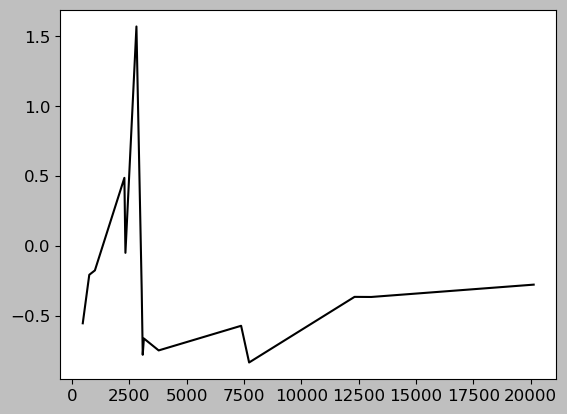

In [117]:
sns.lineplot(x=errors[4], y=errors[0])

## threshold model

In [118]:
from scipy.integrate import quad as num_integrate
from scipy.stats import nbinom

def convert_params(mu, size):
    ''' Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports '''
    p = 1/(1 + mu/size)
    n = size
    return n, p

def nb_size_single(mu):
    ''' gets size parameter for negative binomial from the mean paramter using
        Taylor series approximation, with extra checks along the way.'''
    x = 0
    a = 0
    b = 0
    if mu <= np.exp(-2.538045):
        a = 2.057018
        b = 1.160769
    else:
        a = 6.411532
        b = 1.608689
    if mu <= 0:
        x = 0
    else:
        x = (mu**2) / ((a * mu**b) - mu)
        if x <= 0:
            x = 1e-10
    return x

def nb_size(mus):
    return [nb_size_singe(mu) for mu in mus]

def dnbinom(x, mu, size):
    n, p = convert_params(mu, size)
    return nbinom.pmf(x, n, p)

def posterior_prob(x, thresh, prior):
    prod_dnbinom = lambda mu: np.product(dnbinom(x, mu, nb_size_single(mu)))
    null = num_integrate(lambda mu: prod_dnbinom(mu), thresh, np.inf)[0] * prior
    alt = num_integrate(lambda mu: prod_dnbinom(mu), 0, thresh)[0] * (1-prior)
    return (null) / (alt + null)



In [119]:
AllrCoug2018 = pd.read_csv('verification_data/AllrCoug2018.csv').sort_values(['Date','Traps'])
AllrCoug2018A = pd.read_csv('verification_data/AllrCoug2018A.csv').dropna()
AllrCoug2018 = AllrCoug2018.merge(AllrCoug2018A, on='Date', how='inner')[['Traps','Counts_x','DDs']].rename(columns={'Counts_x':'Counts'})

np.float64(0.09987563635254632)

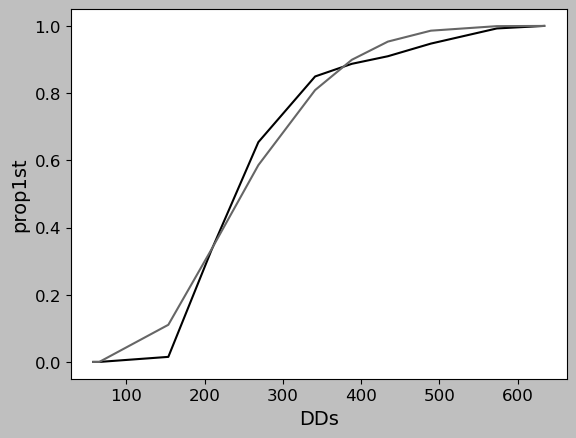

In [120]:
AllrCoug2018_early = AllrCoug2018[AllrCoug2018['DDs'] < 300]
efficacy = predict_from_full(AllrCoug2018A['DDs'], AllrCoug2018A['prop1st'].cumsum())
sns.lineplot(x=AllrCoug2018A['DDs'], y=AllrCoug2018A['prop1st'].cumsum())
sns.lineplot(x=AllrCoug2018A['DDs'], y=capture_prediction_sb_cumul(efficacy, AllrCoug2018A['DDs']))
efficacy

In [121]:
step = 4
x1 = AllrCoug2018_early.iloc[step*30,2]
ys1 = AllrCoug2018_early.iloc[step*30:step*30+30,1]
last_cumul = AllrCoug2018.Counts.cumsum().tail(1).item()
last_average = AllrCoug2018.Counts.cumsum().tail(1).item() / 30
cumul_threshold = 133
avg_threshold = cumul_threshold / 30
y_hat1 = capture_prediction_sb_cumul(efficacy, x1, test_max=avg_threshold)
last_cumul, last_average, y_hat1, ys1.mean()

(133,
 4.433333333333334,
 np.float64(2.596834587113047),
 np.float64(1.4333333333333333))

In [122]:
AllrCoug2019A = pd.read_csv('verification_data/AllrCoug2019A.csv').dropna()
AllrCoug2020A = pd.read_csv('verification_data/AllrCoug2020A.csv').dropna()
AllrCoug2021A = pd.read_csv('verification_data/AllrCoug2021A.csv').dropna()

In [123]:
aggs[14]

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year,moth_sum
1047,103,0.000000,0.000000,13,1.0,149.419465,20,0.0,2015.0,0.0
1048,104,0.000000,0.000000,29,1.0,151.428381,20,0.0,2015.0,0.0
1049,105,0.000000,0.000000,32,1.0,155.490731,20,0.0,2015.0,0.0
1050,106,0.000000,0.000000,12,1.0,162.060122,20,0.0,2015.0,0.0
1051,110,0.000000,0.000000,23,1.0,199.225403,20,0.0,2015.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1147,238,0.000000,0.000000,23,1.0,2689.411286,20,0.0,2015.0,47.0
1148,239,0.000000,0.000000,12,1.0,2709.787286,20,0.0,2015.0,47.0
1149,240,0.000000,0.000000,57,1.0,2730.451286,20,0.0,2015.0,47.0
1150,243,0.000000,0.000000,65,1.0,2778.583286,20,0.0,2015.0,47.0


In [124]:
testdata = pd.read_csv('region_A1a.csv').query('Year == 2015').merge(aggs[14], on='julian', how='inner')[['Wild','DDs','Year','X','Y']]
testdata = testdata.query('DDs < 685')
testdata['moths_cumul'] = testdata.Wild.cumsum()
testdata = testdata.groupby('DDs')
test_dens = densities_oksir.iloc[14].density.item()
print(test_dens)
predicted_eff = f_dens(test_dens,*popt_dens)
print(predicted_eff)
dds = np.array(list(testdata.groups.keys()))

testdata.head()

0.1215
0.07306244114252777


,Wild,DDs,Year,X,Y,moths_cumul
0,0.0,149.419465,2015,-119.580568,49.126713,0.0
1,0.0,149.419465,2015,-119.581150,49.127490,0.0
2,0.0,149.419465,2015,-119.581465,49.128551,0.0
3,0.0,149.419465,2015,-119.578896,49.128906,0.0
4,0.0,149.419465,2015,-119.579639,49.131926,0.0
...,...,...,...,...,...,...
1438,0.0,671.751368,2015,-119.587018,49.151915,26.0
1439,0.0,671.751368,2015,-119.586762,49.157593,26.0
1440,0.0,671.751368,2015,-119.591509,49.157632,26.0
1441,0.0,671.751368,2015,-119.586971,49.158925,26.0


<Axes: ylabel='moths_cumul'>

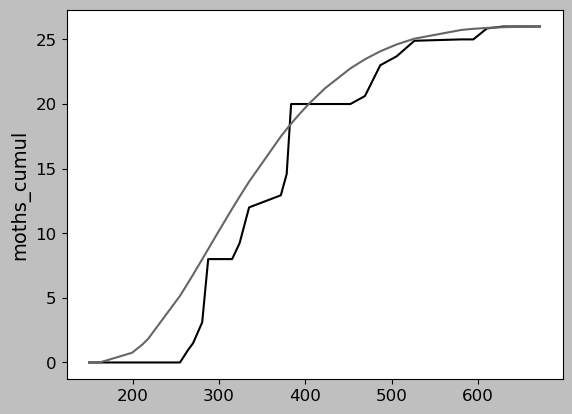

In [125]:
sns.lineplot(x=dds, y=testdata.mean().moths_cumul)
sns.lineplot(x=dds, y=26*capture_prediction_sb_biofix(dds,predicted_eff,biofix=143))